### Курсовая работа №3. Выгрузка, обработка и анализ данных. Малицкий С.В.

In [4]:
# загрузка библиотек
import pandas as pd
import pandas_gbq
from google.oauth2 import service_account

ModuleNotFoundError: No module named 'pandas_gbq'

In [59]:

credentials = service_account.Credentials.from_service_account_file('bigquery_key.json')
pandas_gbq.context.credentials = credentials
pandas_gbq.context.progect = "astute-asset-303615"


____
#### Необходимо сформировать запросы, которые выводят:
ROI по платным каналам трафика (для которых есть данные):

    В сумме по каждому платному источнику.
    В детализации по месяцам.



Вычислим ROI на основе данных из таблиц. Для этого возьмем источники и каналы, а также доходы из таблицы **ga_data**. Из таблиц **g_ads_data**, **admitad_data**, **ya_direct_data** возьмем стоимости рекламных кампаний

____
Запрос для ROI по источникам **yandex, google, admitad** в детализации по месяцам

In [65]:
sql = """

WITH ocosts as (
    SELECT 'admitad' source,  'cpa' medium, date, cost FROM `astute-asset-303615.Project_3.admitad_data`  -- объединение таблиц
    UNION ALL                                                                                             -- берем адмитад, яндекс, гугл, как источники
    SELECT 'yandex'  source,  'cpc' medium, date, cost FROM `astute-asset-303615.Project_3.ya_direct_data`-- сра, срс, как каналы
    UNION ALL                                                                                             -- из таблиц с костами
    SELECT 'google'  source,  'cpc' medium, date, cost FROM `astute-asset-303615.Project_3.g_ads_data`
),
costs as (
    SELECT source, medium, extract(year from date) year, extract(month from date) month, sum(cost) as cost --из таблицы выше ocosts берем соурс, медиум
    FROM ocosts                                                                                            -- извлекаем год и месяц из даты, суммируем косты
    GROUP BY source, medium, year, month                                                                   -- группируем по источику, каналу, году, месяцу
),
ga as (
    SELECT medium, source, extract(year from ga.date) year, extract(month from ga.date) month, sum(ga.revenue) revenue -- из таблицы ga вытаскиваем все то же самое плюс сумму доходов
    FROM `astute-asset-303615.Project_3.ga_data` ga
    WHERE (ga.medium = 'cpa' AND ga.source = 'admitad') OR (ga.medium = 'cpc' AND ga.source in ('google', 'yandex'))
    GROUP BY medium, source, year, month
)
SELECT ga.medium, ga.source, costs.year, costs.month, ga.revenue, costs.cost, (ga.revenue - costs.cost) * 100 / costs.cost ROI
FROM ga
LEFT JOIN  costs on ga.year = costs.year and ga.month = costs.month and ga.source = costs.source
ORDER BY ga.source, ga.year, ga.month

"""
ROI = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|██████████████████████████| 36/36 [00:00<00:00, 127.93rows/s]


In [2]:
ROI = ROI[['medium', 'source', 'month', 'ROI']]

NameError: name 'ROI' is not defined

____
***
#### Маркетинговые метрики в динамике по месяцам:
CTR (при наличии), CPA (стоимость транзакции, при наличии), CR (коэффициент конверсии в транзакцию):

    В разбивке по источник / канал.
    В разбивке по городам (только CR).

**Расчет CTR**

In [7]:
sql = """
SELECT DISTINCT 
   EXTRACT (MONTH FROM `date`) AS month_nmbr,                  -- выгружаю номер месяца из даты
  ROUND(AVG((`productClick`/ `pageviews`) *100), 1) AS CTR,    -- расчет CTR c округлением до 1 знака после запятой
 CONCAT(`source`, '/', `medium`) AS type_ch                    -- объединяю в один столбец канал и источник
FROM
  `astute-asset-303615.Project_3.ga_data`
WHERE
  `pageviews` > 0 AND `productClick` > 0                       -- просмотры и клики должны быть больше, чем 0
GROUP BY 1,3                                                   -- группировка по месяцу и источнику/каналу
ORDER BY 1                                                     -- сортировка по месяцу
"""
CTR = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|████████████████████████| 307/307 [00:00<00:00, 973.83rows/s]


In [8]:
CTR

,month_nmbr,CTR,type_ch
0,1,396.8,yandex/cpc
1,1,320.9,opmcpa/cpa
2,1,368.3,yandex/organic
3,1,355.9,google/organic
4,1,363.6,(direct)/(none)
...,...,...,...
302,12,197.1,bing/organic
303,12,152.8,instagram/social
304,12,276.5,promo/email
305,12,410.9,24ttl/cpa


**Расчет CPA**

In [187]:
sql = """
SELECT   
   EXTRACT (MONTH FROM A.`date`) AS month,                                           --дату в номер месяца
SUM(`transactions`)              AS sum_tran,                                        --сумма транзакций из таблицы А
A.`source` ,                                                                         --источник из таблицы А
SUM(B.`cost`)                         AS google_cost,                                --расходы на гугл из таблицы Б
SUM(C.`cost`)                         AS admitad_cost, 
SUM(D.`cost`)                         AS ya_cost,

CASE WHEN A.`source` = 'google'  THEN ROUND((SUM(B.`cost`) / SUM(`transactions`)), 2) --кейс, в случае, когда запрос видит необходимый источник в source,  
     WHEN A.`source` = 'yandex'  THEN ROUND((SUM(D.`cost`) / SUM(`transactions`)), 2) --то считает CPA с учетом расходов именно этого
     WHEN A.`source` = 'admitad' THEN ROUND((SUM(C.`cost`) / SUM(`transactions`)), 2) --источника
END as CPA_google_yandex_admitad
   
FROM `astute-asset-303615.Project_3.ga_data` as A 
LEFT JOIN `astute-asset-303615.Project_3.g_ads_data` as B                             -- джойны таблиц по датам
ON A.`date` = B.`date`
LEFT JOIN `astute-asset-303615.Project_3.admitad_data` as C 
ON A.`date` = C.`date`
LEFT JOIN `astute-asset-303615.Project_3.ya_direct_data` as D
ON A.`date` = D.`date`


WHERE `transactions` > 0 AND (`source` = 'google' OR `source` = 'admitad' OR `source` = 'yandex') /* количество транзакций не должно быть равно нулю, а источники только 
гугл, яндекс и адмидат, т.к. данные по рекламным расходам имеются только у этих источников */


GROUP BY 1, 3                                                                         -- группировка по номеру месяца и источнику
ORDER BY `month`                                                                      -- сортировка по месяцу

"""
CPA = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")


Downloading: 100%|██████████████████████████| 36/36 [00:00<00:00, 118.94rows/s]


In [188]:
CPA[['month', 'source', 'CPA_google_yandex_admitad']]

,month,source,CPA_google_yandex_admitad
0,1,yandex,138186.32
1,1,google,74926.43
2,1,admitad,1164.39
3,2,google,100401.03
4,2,yandex,170198.98
5,2,admitad,40226.31
6,3,yandex,146225.44
7,3,admitad,31624.01
8,3,google,94414.11
9,4,yandex,157515.50


**Расчет CR в детализации по месяцам в разбивке источник/канал**

In [11]:
sql = """
SELECT  DISTINCT 

EXTRACT (MONTH FROM `date`) AS month_nmbr,                           --дату в номер месяца
CONCAT(`source`, '/', `medium`) AS type_ch,                          --объединение источника и канала в один столбец
SUM(`transactions`) AS sum_tr,                                       --суммирую транзакции и клики по месяцам
SUM(`productClick`) AS sum_prdc,

 ROUND((SUM(`transactions`) / SUM(`productClick`) * 100), 2) as CR   --расчет конверсии, с округлением до одного знака после запятой

FROM `astute-asset-303615.Project_3.ga_data` 

WHERE `transactions`>0 AND `productClick`>0                           --транзакции и клики больше 0

GROUP BY 1,2                                                          --группировка по номеру месяца и источнику/каналу
ORDER BY 1                                                            --группировка по номеру месяца

"""
CR_month = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|████████████████████████| 289/289 [00:00<00:00, 616.17rows/s]


In [12]:
CR_month[['month_nmbr', 'type_ch', 'CR']]

,month_nmbr,type_ch,CR
0,1,yandex/cpc,3.15
1,1,(direct)/(none),3.21
2,1,yandex/organic,3.37
3,1,google/cpc,3.30
4,1,google/organic,3.40
...,...,...,...
284,12,facebook/cpc,2.37
285,12,promo/email,4.00
286,12,sellaction/cpa,2.36
287,12,facebook/social,2.00


**Расчет CR в детализации по месяцам в разбивке по городам**

In [13]:
sql = """
SELECT  DISTINCT 

EXTRACT (MONTH FROM `date`) AS month_nmbr,                           --дату в номер месяца
`city` ,                                                             
SUM(`transactions`) AS sum_tr,                                       --суммирую транзакции и клики по месяцам
SUM(`productClick`) AS sum_prdc,

 ROUND((SUM(`transactions`) / SUM(`productClick`) * 100), 2) as CR   --расчет конверсии, с округлением до одного знака после запятой

FROM `astute-asset-303615.Project_3.ga_data` 

WHERE `transactions`>0 AND `productClick`>0

GROUP BY 1,2
ORDER BY 1

"""
CR_city = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████| 642/642 [00:00<00:00, 1890.08rows/s]


In [14]:
CR_city[['month_nmbr', 'city', 'CR']]

,month_nmbr,city,CR
0,1,Москва,3.06
1,1,Не определено,3.38
2,1,Сходня,3.22
3,1,Томск,3.85
4,1,Екатеринбург,3.66
...,...,...,...
637,12,Фрязино,2.56
638,12,Электросталь,3.99
639,12,Новокузнецк,3.17
640,12,Пушкино,3.31


____
***
### Воронку продажи (сеансы, клик по товару, корзина, чекаут, транзакция, конверсия из сеансов в каждый из этапов):

    В разбивке по пользователям, которые использовали и не использовали фильтр.
    В разбивке по разным устройствам.
    В разбивке по возможности доставки.


Воронки отображены в следующем виде: 
- столбцы **без отметки CR** в названии являются суммой всех значений за все время (число);
- столбцы **с отметкой CR** в названии являются процентом конверсии, обозначающего переход пользователей от одного действия к другому (процент).

In [15]:
sql = """

SELECT  
SUM(`visits`)                                         as visits,                --суммирую все метрики, необходимые для воронки
ROUND(((SUM(`productClick`)/SUM(`visits`))*100),0)    as CR_visits_to_clicks,   --делю каждый последующий этап воронки на предыдущий
SUM(`productClick`)                                   as productClick,
ROUND(((SUM(`addToCart`)/SUM(`productClick`))*100),0) as CR_clicks_to_cart,     --и нахожу процент
SUM(`addToCart`)                                      as addToCart,             --методика одинакова во всех воронках, находящихся ниже
ROUND(((SUM(`checkout`)/SUM(`addToCart`))*100),0)     as CR_cart_to_checkout,
SUM(`checkout`)                                       as checkout,
ROUND(((SUM(`transactions`)/SUM(`checkout`))*100),0)  as CR_checkout_to_transactions,
SUM(`transactions`)                                   as transactions

FROM `astute-asset-303615.Project_3.ga_data` 

WHERE `filter_used` > 0

"""
funnel_1 = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|█████████████████████████████| 1/1 [00:00<00:00,  2.47rows/s]


**Воронка продаж в разбивке по пользователям, не использовавших фильтр**

In [16]:
funnel_1

,visits,CR_visits_to_clicks,productClick,CR_clicks_to_cart,addToCart,CR_cart_to_checkout,checkout,CR_checkout_to_transactions,transactions
0,184999,2104.0,3892800,20.0,777692,78.0,609779,10.0,63448


In [17]:
sql = """

SELECT 

`device_type`,
SUM(`visits`)                                         as visits,
ROUND(((SUM(`productClick`)/SUM(`visits`))*100),0)    as CR_visits_to_clicks,
SUM(`productClick`)                                   as productClick,
ROUND(((SUM(`addToCart`)/SUM(`productClick`))*100),0) as CR_clicks_to_cart,
SUM(`addToCart`)                                      as addToCart,
ROUND(((SUM(`checkout`)/SUM(`addToCart`))*100),0)     as CR_cart_to_checkout,
SUM(`checkout`)                                       as checkout,
ROUND(((SUM(`transactions`)/SUM(`checkout`))*100),0)  as CR_checkout_to_transactions,
SUM(`transactions`)                                   as transactions

FROM `astute-asset-303615.Project_3.ga_data` 

GROUP BY 1

"""
funnel_2 = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|█████████████████████████████| 3/3 [00:00<00:00, 11.16rows/s]


**Воронка продаж в разбивке по устройствам**

In [18]:
funnel_2

,device_type,visits,CR_visits_to_clicks,productClick,CR_clicks_to_cart,addToCart,CR_cart_to_checkout,checkout,CR_checkout_to_transactions,transactions
0,Десктоп,2980928,981.0,29234090,20.0,5823900,67.0,3898570,14.0,535638
1,Мобайл,5615287,617.0,34650970,20.0,6926550,108.0,7468706,9.0,690906
2,Не определено,536881,0.0,150,20.0,30,113.0,34,572641.0,194698


In [19]:
sql = """

SELECT 

`delivery_available`,
SUM(`visits`)                                         as visits,
ROUND(((SUM(`productClick`)/SUM(`visits`))*100),0)    as CR_visits_to_clicks,
SUM(`productClick`)                                   as productClick,
ROUND(((SUM(`addToCart`)/SUM(`productClick`))*100),0) as CR_clicks_to_cart,
SUM(`addToCart`)                                      as addToCart,
ROUND(((SUM(`checkout`)/SUM(`addToCart`))*100),0)     as CR_cart_to_checkout,
SUM(`checkout`)                                       as checkout,
ROUND(((SUM(`transactions`)/SUM(`checkout`))*100),0)  as CR_checkout_to_transactions,
SUM(`transactions`)                                   as transactions

FROM `astute-asset-303615.Project_3.ga_data` 

GROUP BY 1

"""
funnel_3 = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|█████████████████████████████| 3/3 [00:00<00:00, 11.23rows/s]


**Воронка продаж в разбивке по возможности доставки**

In [20]:
funnel_3

,delivery_available,visits,CR_visits_to_clicks,productClick,CR_clicks_to_cart,addToCart,CR_cart_to_checkout,checkout,CR_checkout_to_transactions,transactions
0,Не определено,8504854,540.0,45900820,20.0,9159282,78.0,7167364,14.0,968816
1,Доставка есть,609746,2863.0,17457290,20.0,3486028,117.0,4092285,11.0,446109
2,Доставки нет,18496,2850.0,527100,20.0,105170,102.0,107661,6.0,6317


___
***
#### Необходимо провести первичную аналитику полученных данных

**Она должна содержать:**

    Меры центральной тенденции, меры разброса данных, квантили;
    Выводы о характеристиках выборки, наличии выбросов;
    Диаграммы распределения, визуализация основных показателей в статике по категориям и в динамике по датам.


## CPA

In [148]:
# повторяю запрос с СРА, но в селекте вызываю уже не номер месяца, а полные даты

sql = """
SELECT   
   A.`date`,            
SUM(`transactions`)                    AS sum_tran,         --сумма транзакций из таблицы А
A.`source` ,                                                --источник из таблицы А
SUM(B.`cost`)                          AS google_cost,      --расходы на гугл из таблицы Б
SUM(C.`cost`)                          AS admitad_cost, 
SUM(D.`cost`)                          AS ya_cost,
CASE WHEN A.`source` = 'google'  THEN (SUM(B.`cost`) / SUM(`transactions`)) --кейс, в случае, когда запрос видит необходимый источник в source,  
     WHEN A.`source` = 'yandex'  THEN (SUM(D.`cost`) / SUM(`transactions`)) -- то считает CPA с учетом расходов именно этого
     WHEN A.`source` = 'admitad' THEN (SUM(C.`cost`) / SUM(`transactions`)) --источника
END                                    AS CPA_google_yandex_admitad
   
FROM `astute-asset-303615.Project_3.ga_data` as A 
LEFT JOIN `astute-asset-303615.Project_3.g_ads_data` as B
ON A.`date` = B.`date`
LEFT JOIN `astute-asset-303615.Project_3.admitad_data` as C 
ON A.`date` = C.`date`
LEFT JOIN `astute-asset-303615.Project_3.ya_direct_data` as D
ON A.`date` = D.`date`


WHERE `transactions` > 0 AND (`source` = 'google' OR `source` = 'admitad' OR `source` = 'yandex') 
/* количество транзакций не должно быть равно нулю, а источники только 
гугл, яндекс и адмидат, т.к. данные по рекламным расходам имеются только у этих источников */


GROUP BY 1, 3
ORDER BY 1
"""
CPA_2 = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")
CPA_3 = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|█████████████████████| 1096/1096 [00:00<00:00, 2422.02rows/s]


In [149]:
#загрузка библиотек
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn import preprocessing
import seaborn as sns
import scipy.stats as scs
import matplotlib.pyplot as plt 


In [150]:
import matplotlib.pyplot as plt
from itertools import groupby
import numpy as np 
%matplotlib inline

In [151]:
#сделал столбец "дата" индексом таблицы, для наглядности графиков

CPA_2.index = CPA_2['date']
CPA_2 = CPA_2.drop(['date'], axis = 1)

CPA_2

,sum_tran,source,google_cost,admitad_cost,ya_cost,CPA_google_yandex_admitad
date,,,,,,
2020-01-01,1463,google,1.358001e+08,1591603.20,1.421954e+08,92823.010253
2020-01-01,1104,yandex,1.021330e+08,1197018.24,1.069428e+08,96868.464130
2020-01-01,10,admitad,7.544448e+05,8842.24,7.899744e+05,884.224000
2020-01-02,1779,google,2.040897e+08,1422971.55,2.394101e+08,114721.558179
2020-01-02,1581,yandex,1.805990e+08,1259187.93,2.118540e+08,134000.030361
...,...,...,...,...,...,...
2020-12-30,2033,yandex,1.648037e+08,946053.30,2.453739e+08,120695.456665
2020-12-30,3,admitad,2.479494e+05,1423.35,3.691683e+05,474.450000
2020-12-31,1484,yandex,1.102921e+08,496403.97,1.764771e+08,118919.886792


**Построим ниже график с целью ознакомления с данными с разбивкой по датам**

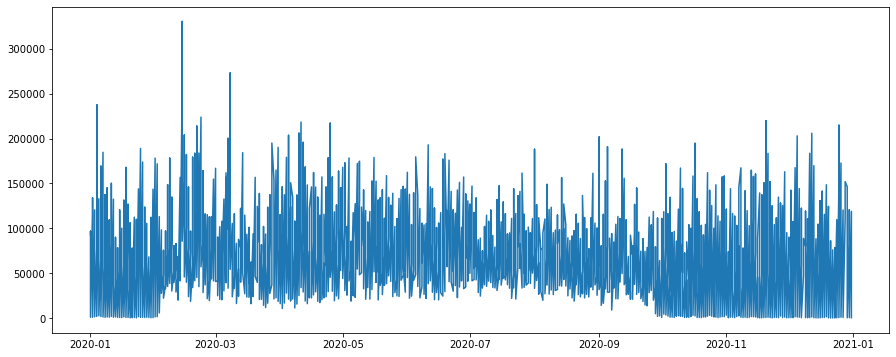

In [152]:

plt.figure(figsize = (15, 6))
plt.plot(CPA_2['CPA_google_yandex_admitad'])

In [265]:
# Произвожу группировку по дате и источнику, чтобы построить график для выявления закономерностей и выводов

CPA_2_ = CPA_2.groupby(['date', 'source']).sum()
CPA_2_

sum_tran   google_cost  admitad_cost       ya_cost  \
date       source                                                        
2020-01-01 admitad        10  7.544448e+05       8842.24  7.899744e+05   
           google       1463  1.358001e+08    1591603.20  1.421954e+08   
           yandex       1104  1.021330e+08    1197018.24  1.069428e+08   
2020-01-02 admitad         9  1.046614e+06       7297.29  1.227744e+06   
           google       1779  2.040897e+08    1422971.55  2.394101e+08   
...                      ...           ...           ...           ...   
2020-12-30 google       1870  1.521583e+08     873462.45  2.265463e+08   
           yandex       2033  1.648037e+08     946053.30  2.453739e+08   
2020-12-31 admitad         2  1.509816e+05        679.54  2.415840e+05   
           google       1463  1.087822e+08     489608.57  1.740613e+08   
           yandex       1484  1.102921e+08     496403.97  1.764771e+08   

                    CPA_google_yandex_admitad          Mean  
date       source                                            
2020-01-01 admitad                 884.224000  74969.542286  
           google                92823.010253  74969.542286  
           yandex                96868.464130  74969.542286  
2020-01-02 admitad                 810.810000  74969.542286  
           google               114721.558179  74969.542286  
...                                       ...           ...  
2020-12-30 google                81368.065134  74969.542286  
           yandex               120695.456665  74969.542286  
2020-12-31 admitad                 339.770000  74969.542286  
           google                74355.600000  74969.542286  
           yandex               118919.886792  74969.542286  

[1096 rows x 6 columns]

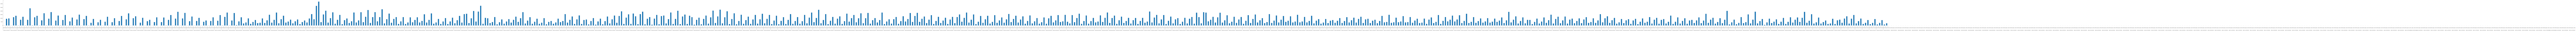

In [154]:
def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)
def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]
def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

fig, ax = plt.subplots(figsize = (800, 8))
ax = CPA_2_['CPA_google_yandex_admitad'].plot(kind='bar',stacked=False)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
label_group_bar_table(ax, CPA_2_['CPA_google_yandex_admitad'])

# ДВОЙНОЙ КЛИК ПО ГРАФИКУ ДЛЯ ДЕТАЛЬНОГО ИЗУЧЕНИЯ

На данном графике наблюдаются следующие закономерности:
    
    - на протяжении всего графика наивысший СРА среди трех источников ВСЕГДА у Яндекса;
    - в некоторые дни СРА Гугла близок к выравниванию с СРА Яндекса;
    - весь Январь у источника Адмитад рекордно низкий СРА, и вырастает он в начале Февраля;
    - максимальные приросты СРА  у всех трех источников наблюдаются 14 Февраля и 8 Марта;
    - также просматривается некая волнообразная закономерность: в начале и конце месяца наблюдаются незначительные приросты СРА, в середине - провалы.

### Среднее значение (CPA)

In [155]:
# Добавил столбец средних значений СРА в таблицу, чтобы построить график

CPA_2['Mean'] = CPA_2['CPA_google_yandex_admitad'].mean()
CPA_2

,sum_tran,source,google_cost,admitad_cost,ya_cost,CPA_google_yandex_admitad,Mean
date,,,,,,,
2020-01-01,1463,google,1.358001e+08,1591603.20,1.421954e+08,92823.010253,74969.542286
2020-01-01,1104,yandex,1.021330e+08,1197018.24,1.069428e+08,96868.464130,74969.542286
2020-01-01,10,admitad,7.544448e+05,8842.24,7.899744e+05,884.224000,74969.542286
2020-01-02,1779,google,2.040897e+08,1422971.55,2.394101e+08,114721.558179,74969.542286
2020-01-02,1581,yandex,1.805990e+08,1259187.93,2.118540e+08,134000.030361,74969.542286
...,...,...,...,...,...,...,...
2020-12-30,2033,yandex,1.648037e+08,946053.30,2.453739e+08,120695.456665,74969.542286
2020-12-30,3,admitad,2.479494e+05,1423.35,3.691683e+05,474.450000,74969.542286
2020-12-31,1484,yandex,1.102921e+08,496403.97,1.764771e+08,118919.886792,74969.542286


74969.54228577662


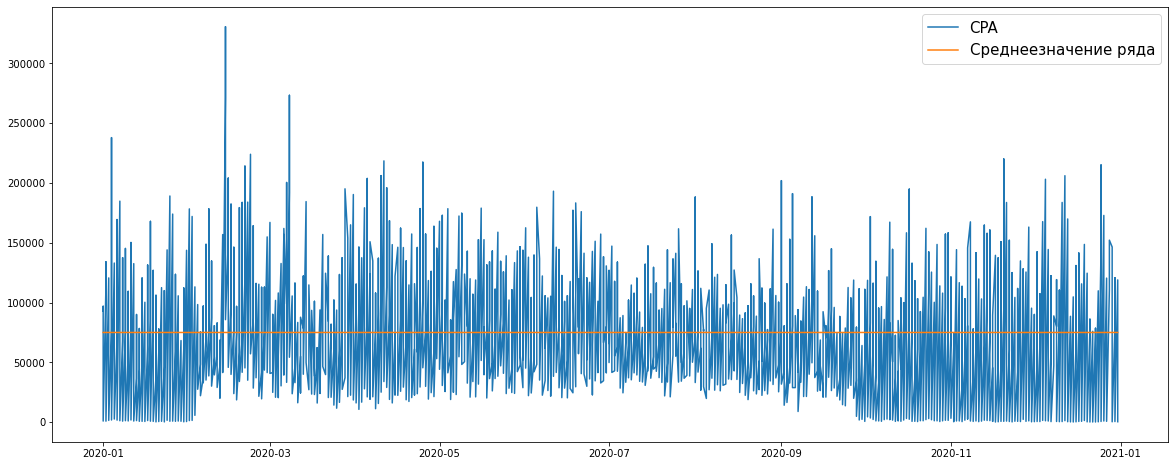

In [156]:
plt.figure(figsize = (20, 8))
plt.plot(CPA_2['CPA_google_yandex_admitad'], label = 'CPA' )
plt.plot(CPA_2['Mean'], label = 'Среднеезначение ряда')
plt.legend(prop={'size': 15})

## Среднее значение
print(CPA_2['CPA_google_yandex_admitad'].sort_values().mean())

### Медиана (CPA)

In [157]:
# создаю столбец в таблице с индексами равными стандартным. Заменяю одни на другие. Затем удаляю созданный столбец. 
# Это необходимо для того, чтобы я мог удалить строку, т.к. их нечетное количество. Медиану необходимо искать по четному кол-ву 

CPA_3['index'] = range(0,1096,1)
CPA_3.index = CPA_3['index']
CPA_3 = CPA_3.drop(['index'], axis = 1)
CPA_3

,date,sum_tran,source,google_cost,admitad_cost,ya_cost,CPA_google_yandex_admitad
index,,,,,,,
0,2020-01-01,1463,google,1.358001e+08,1591603.20,1.421954e+08,92823.010253
1,2020-01-01,1104,yandex,1.021330e+08,1197018.24,1.069428e+08,96868.464130
2,2020-01-01,10,admitad,7.544448e+05,8842.24,7.899744e+05,884.224000
3,2020-01-02,1779,google,2.040897e+08,1422971.55,2.394101e+08,114721.558179
4,2020-01-02,1581,yandex,1.805990e+08,1259187.93,2.118540e+08,134000.030361
...,...,...,...,...,...,...,...
1091,2020-12-30,2033,yandex,1.648037e+08,946053.30,2.453739e+08,120695.456665
1092,2020-12-30,3,admitad,2.479494e+05,1423.35,3.691683e+05,474.450000
1093,2020-12-31,1484,yandex,1.102921e+08,496403.97,1.764771e+08,118919.886792


In [158]:
# удаляю одну строку, чтобы их было четное количество

CPA_3 = CPA_3.drop([1095], axis = 'index')

In [159]:
# создаю новый столбец с отсортированными значениями СРА, т.к. медиана работает только на последовательной выборке

CPA_3['CPA_sort'] = CPA_3['CPA_google_yandex_admitad'].sort_values(ignore_index=True)
CPA_3

,date,sum_tran,source,google_cost,admitad_cost,ya_cost,CPA_google_yandex_admitad,CPA_sort
index,,,,,,,,
0,2020-01-01,1463,google,1.358001e+08,1591603.20,1.421954e+08,92823.010253,84.370000
1,2020-01-01,1104,yandex,1.021330e+08,1197018.24,1.069428e+08,96868.464130,108.970000
2,2020-01-01,10,admitad,7.544448e+05,8842.24,7.899744e+05,884.224000,109.370000
3,2020-01-02,1779,google,2.040897e+08,1422971.55,2.394101e+08,114721.558179,109.890000
4,2020-01-02,1581,yandex,1.805990e+08,1259187.93,2.118540e+08,134000.030361,111.070000
...,...,...,...,...,...,...,...,...
1090,2020-12-30,1870,google,1.521583e+08,873462.45,2.265463e+08,81368.065134,223947.451027
1091,2020-12-30,2033,yandex,1.648037e+08,946053.30,2.453739e+08,120695.456665,237872.166189
1092,2020-12-30,3,admitad,2.479494e+05,1423.35,3.691683e+05,474.450000,271226.424652


In [160]:
# индекс в таблице, где находится медианное значение

(len(CPA_3['CPA_sort'])-1)/2

547.0

In [161]:
# проверяю соответсвует ли медианное значение индексу из таблицы

CPA_3[CPA_3['CPA_sort'] == CPA_3['CPA_sort'].median()]

,date,sum_tran,source,google_cost,admitad_cost,ya_cost,CPA_google_yandex_admitad,CPA_sort
index,,,,,,,,
547,2020-07-01,1585,yandex,103979372.2,79298303.92,201065950.8,126855.489464,69560.218642


In [35]:
# вновь созданный столбец "Медиана" приравниваю к нулю
# 547 строку приравниваю к 300000 это и есть значение индекса медианы из таблицы

CPA_3['Median']=0
CPA_3.loc[547, 'Median']=300000
CPA_3['Median'].sum()

300000

69560.21864211738


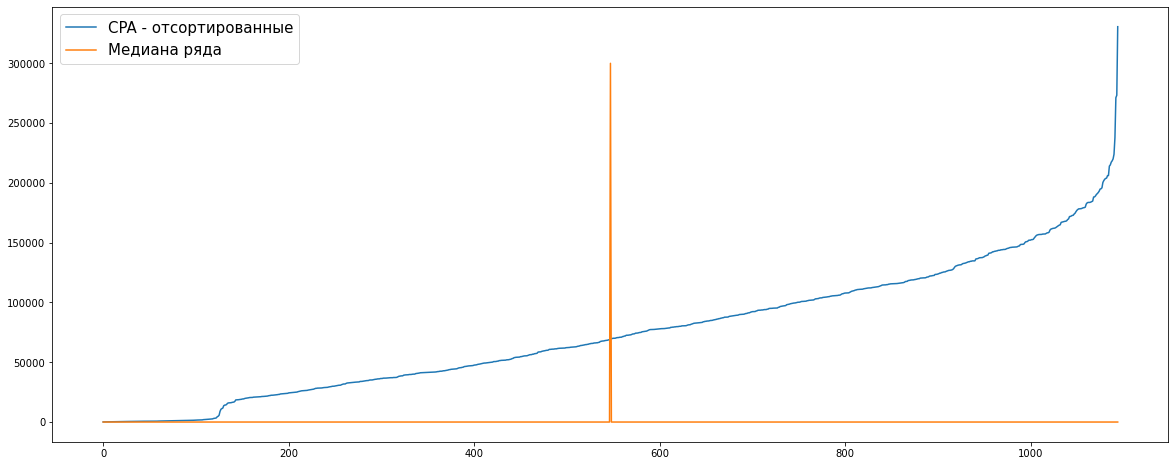

In [36]:
plt.figure(figsize = (20, 8))
plt.plot(CPA_3['CPA_sort'], label = 'CPA - отсортированные' )
plt.plot(CPA_3['Median'], label = 'Медиана ряда')
plt.legend(prop={'size': 15})

## Медиана
print(CPA_3['CPA_sort'].sort_values().median())

### Дисперсия и стандартное отклонение (CPA)

In [37]:
CPA_3['CPA_sort'].var()

2790479004.30256

In [38]:
CPA_3['CPA_sort'].std()

52824.98465974751

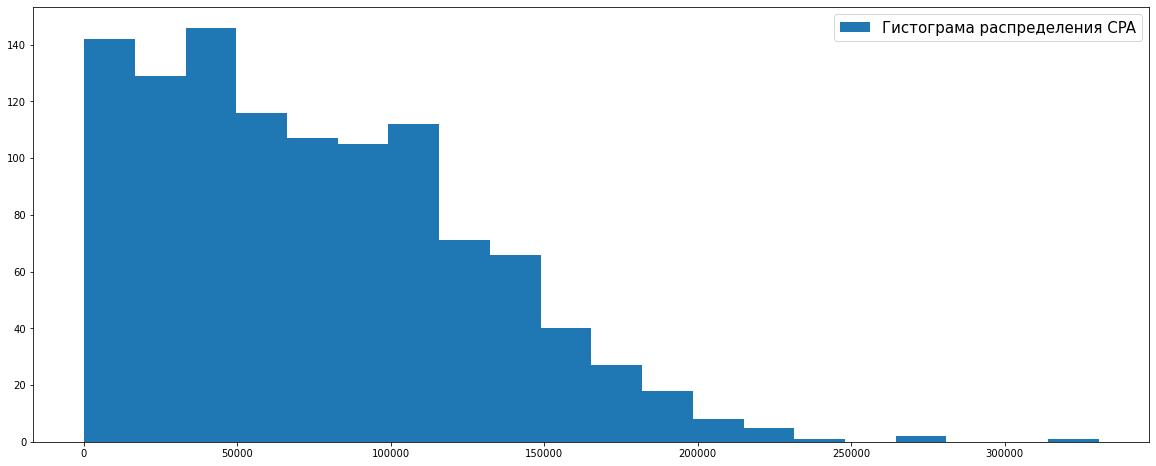

In [393]:
plt.figure(figsize = (20, 8))
plt.hist(CPA_2['CPA_google_yandex_admitad'], bins=20, label ='Гистограма распределения CPA') 
plt.legend(prop={'size': 15})
plt.show()

Данный график указывает на отклонение распределения от нормального закона. Исходя из этого, медиана - более точный показатель среднего значения, нежели среднее арифметическое (менее устойчивое к выбросам)

### Квантили и выбросы (CPA)

In [166]:
print('95% квантиль равен:')
CPA_3['CPA_google_yandex_admitad'].quantile(.95)


95% квантиль равен:


168653.58499737788

In [169]:
print('50% квантиль равен:')
CPA_3['CPA_google_yandex_admitad'].quantile(.5)

50% квантиль равен:


69560.21864211738

In [170]:
print('99% квантиль равен:')
CPA_3['CPA_google_yandex_admitad'].quantile(.99)

99% квантиль равен:


206043.68700178093

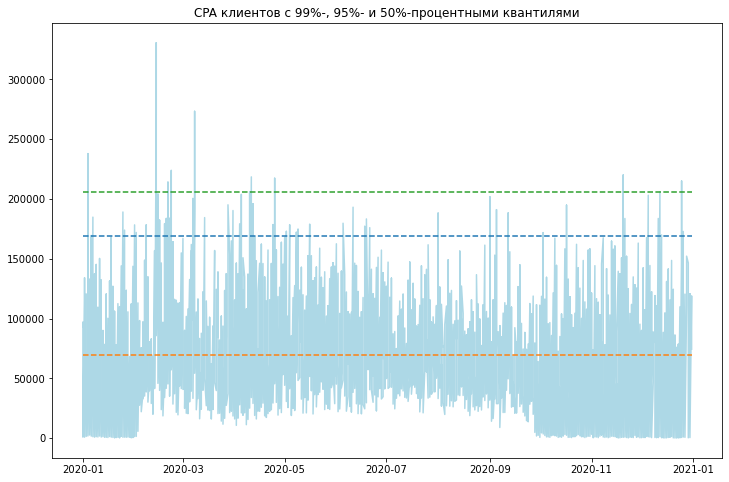

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 8))
plt.plot(CPA_3['date'], CPA_3['CPA_google_yandex_admitad'], color = '#add8e6')
plt.plot((CPA_3['date'][0], CPA_3['date'].iloc[-1]), 
         (CPA_3['CPA_google_yandex_admitad'].quantile(.95), CPA_3['CPA_google_yandex_admitad'].quantile(.95)), label = 'Q1',
        ls = '--')



plt.plot((CPA_3['date'][0], CPA_3['date'].iloc[-1]), 
         (CPA_3['CPA_google_yandex_admitad'].quantile(.5), CPA_3['CPA_google_yandex_admitad'].quantile(.5)), label = 'Q1',
        ls = '--')

plt.plot((CPA_3['date'][0], CPA_3['date'].iloc[-1]), 
         (CPA_3['CPA_google_yandex_admitad'].quantile(.99), CPA_3['CPA_google_yandex_admitad'].quantile(.99)), label = 'Q1',
        ls = '--')
plt.title('CPA клиентов с 99%-, 95%- и 50%-процентными квантилями')

plt.show()

 99% квантиль говорит нам о том, что ниже значения CPA в **206042** лежат 99% значений. Следовательно, те значения, которые мы видим на графике выше этого квантиля гарантировано являются выбросами в данной выборке.

Предположим, что 95% данных достаточно для того, чтобы утверждать, что они не являются выбросами. Исходя из этого значения, находящиеся выше **168602** будем считать выбросами.

Найдем более точным методом аномалии с помощью Isolation Forest

In [72]:
# 95% квантиль с 5% доверительным интервалом

CPA_2['label'] = [1 if (i < CPA_2['CPA_google_yandex_admitad'].quantile(.025)) or 
                      (i > CPA_2['CPA_google_yandex_admitad'].quantile(.975)) else 0 for i in CPA_2['CPA_google_yandex_admitad']]
CPA_2

,sum_tran,source,google_cost,admitad_cost,ya_cost,CPA_google_yandex_admitad,Mean,label
date,,,,,,,,
2020-01-01,1463,google,1.358001e+08,1591603.20,1.421954e+08,92823.010253,74969.542286,0
2020-01-01,1104,yandex,1.021330e+08,1197018.24,1.069428e+08,96868.464130,74969.542286,0
2020-01-01,10,admitad,7.544448e+05,8842.24,7.899744e+05,884.224000,74969.542286,0
2020-01-02,1779,google,2.040897e+08,1422971.55,2.394101e+08,114721.558179,74969.542286,0
2020-01-02,1581,yandex,1.805990e+08,1259187.93,2.118540e+08,134000.030361,74969.542286,0
...,...,...,...,...,...,...,...,...
2020-12-30,2033,yandex,1.648037e+08,946053.30,2.453739e+08,120695.456665,74969.542286,0
2020-12-30,3,admitad,2.479494e+05,1423.35,3.691683e+05,474.450000,74969.542286,1
2020-12-31,1484,yandex,1.102921e+08,496403.97,1.764771e+08,118919.886792,74969.542286,0


In [73]:
# разделим группы на тестовую и тренировочную выборки

from sklearn.model_selection import train_test_split
X = CPA_2['CPA_google_yandex_admitad'].to_numpy().reshape(-1, 1)
y = CPA_2['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123)

In [74]:
from sklearn.ensemble import IsolationForest

In [75]:
# Создадим и обучим модель

i_for = IsolationForest(n_estimators = 150, random_state = 123, bootstrap=True)
i_for.fit(X_train)

IsolationForest(bootstrap=True, n_estimators=150, random_state=123)

In [76]:
# предскажем значения на тренировочной и тестовой выборках
pred_train = i_for.predict(X_train)
pred_test = i_for.predict(X_test)

In [77]:
data_123 = pd.DataFrame(pred_test)
data_123['real'] = X_test
data_123

,0,real
0,1,105593.082969
1,1,34123.850492
2,1,49813.699530
3,1,38574.240674
4,1,87283.714286
...,...,...
105,1,104197.962105
106,-1,57120.205182
107,1,120576.502147
108,-1,164680.152176


Ниже приведены данные, являющиеся выбросами

In [78]:
#аномалии

data_123[data_123[0]!=1]

,0,real
7,-1,126668.488446
8,-1,179197.372924
9,-1,32301.568490
10,-1,197.140000
14,-1,324.410000
20,-1,56728.775494
22,-1,2069.260000
24,-1,158801.403387
27,-1,16044.529941
32,-1,138844.153637


________
***


## ARPU

Осуществим выгрузку ARPU из Big Query

In [46]:
sql = """

    `date`,                                                       --выгрузка по дате
    ROUND((SUM(`revenue`)/COUNT(DISTINCT  `clientId`)), 2)  ARPU, -- формула АРПУ

FROM `astute-asset-303615.Project_3.ga_data`

GROUP BY 1
ORDER BY `date`

"""
ARPU = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████| 366/366 [00:00<00:00, 1121.23rows/s]


In [176]:
sql = """

SELECT  
    
   EXTRACT (MONTH FROM `date`) AS month,                          --выгрузка по номеру месяца
    ROUND((SUM(`revenue`)/COUNT(DISTINCT  `clientId`)), 2)  ARPU, -- формула АРПУ

FROM `astute-asset-303615.Project_3.ga_data`

GROUP BY 1
ORDER BY 1

"""
ARPU_2 = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████████| 12/12 [00:00<00:00, 17.45rows/s]


In [182]:
ARPU_2_grp = ARPU_2.groupby(['month']).sum()

In [47]:
ARPU

,date,ARPU
0,2020-01-01,207.87
1,2020-01-02,225.75
2,2020-01-03,227.24
3,2020-01-04,233.59
4,2020-01-05,238.33
...,...,...
361,2020-12-27,291.26
362,2020-12-28,282.94
363,2020-12-29,310.29
364,2020-12-30,337.41


In [48]:
# Делаю групбай, чтобы построить график по датам


ARPU_grp = ARPU.groupby(['date']).sum()

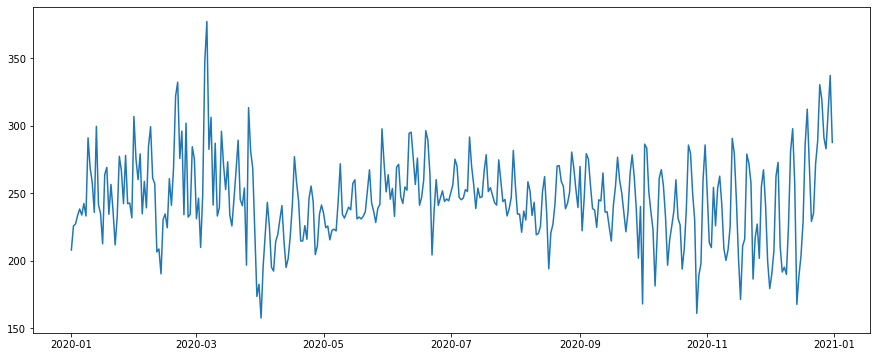

In [49]:
# построим график с целью ознакомления с метрикой по датам

plt.figure(figsize = (15, 6))
plt.plot(ARPU_grp)

График для анализа **ARPU** по дням

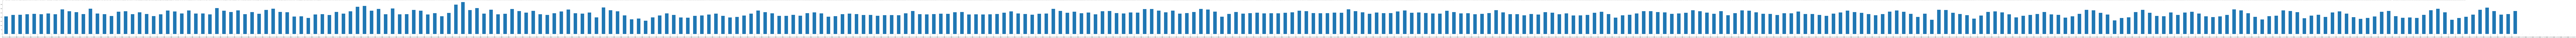

In [50]:
def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)
def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]
def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

fig, ax = plt.subplots(figsize = (600, 8))
ax = ARPU_grp['ARPU'].plot(kind='bar',stacked=False)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
label_group_bar_table(ax, ARPU_grp['ARPU'])

# ДВОЙНОЙ КЛИК ПО ГРАФИКУ ДЛЯ ДЕТАЛЬНОГО ИЗУЧЕНИЯ

По итогам анализа данного графика установлено, что прирост ARPU происходит перед февральскими праздниками 
(14 фервля / 23 февраля) 

и 8 марта

### Среднее значение (ARPU)

245.5142622950821


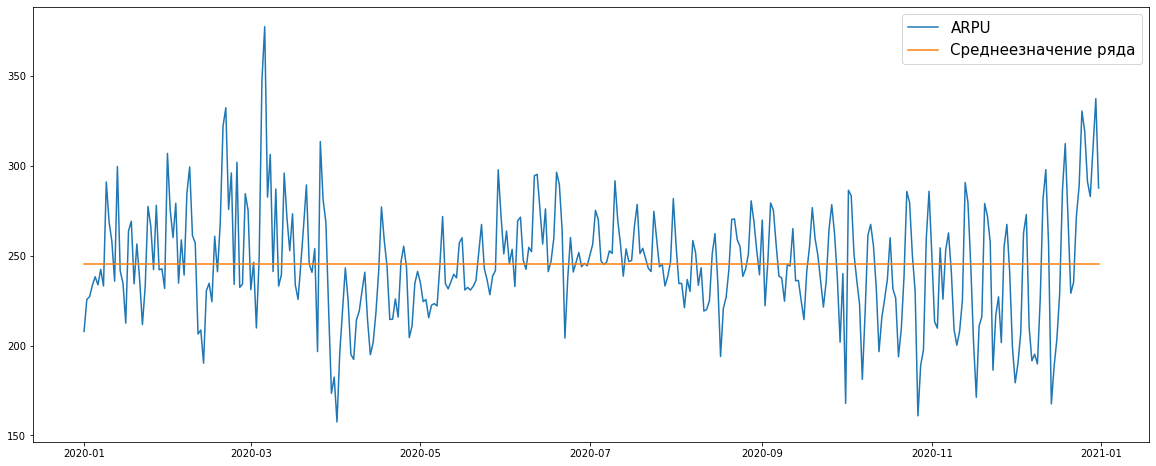

In [51]:
# Добавил столбец средних значений СРА в таблицу, чтобы построить график

ARPU_grp['Mean'] = ARPU['ARPU'].mean()
plt.figure(figsize = (20, 8))
plt.plot(ARPU_grp['ARPU'], label = 'ARPU' )
plt.plot(ARPU_grp['Mean'], label = 'Среднеезначение ряда')
plt.legend(prop={'size': 15})

## Среднее значение
print(ARPU_grp['ARPU'].sort_values().mean())

### Медиана (ARPU)

In [52]:
# создаю столбец в таблице с индексами равными стандартным. Заменяю одни на другие. Затем удаляю созданный столбец.  

ARPU['index'] = range(0,366,1)
ARPU.index = ARPU['index']
ARPU = ARPU.drop(['index'], axis = 1)
ARPU

,date,ARPU
index,,
0,2020-01-01,207.87
1,2020-01-02,225.75
2,2020-01-03,227.24
3,2020-01-04,233.59
4,2020-01-05,238.33
...,...,...
361,2020-12-27,291.26
362,2020-12-28,282.94
363,2020-12-29,310.29


In [53]:
# создаю столбец с сортированными значениями, т.к. медиана определяется по упорядоченному ряду

ARPU['ARPU_sort'] = ARPU['ARPU'].sort_values(ignore_index=True)
ARPU

,date,ARPU,ARPU_sort
index,,,
0,2020-01-01,207.87,157.47
1,2020-01-02,225.75,160.92
2,2020-01-03,227.24,167.59
3,2020-01-04,233.59,167.89
4,2020-01-05,238.33,171.24
...,...,...,...
361,2020-12-27,291.26,330.54
362,2020-12-28,282.94,332.38
363,2020-12-29,310.29,337.41


In [54]:
# удаляю один столбец, чтобы их было нечетное количество для определения целочисленного порядкового номера

ARPU = ARPU.drop([365], axis = 'index')

In [55]:
# индекс в таблице, где находится медианное значение

(len(ARPU['ARPU_sort'])-1)/2

182.0

In [56]:
# соответствие номера индекса и значения ARPU

ARPU[ARPU['ARPU_sort'] == ARPU['ARPU_sort'].median()]

,date,ARPU,ARPU_sort
index,,,
182,2020-07-01,250.47,243.03


In [57]:
# вновь созданный столбец "Медиана" приравниваю к нулю
# 182 строку приравниваю к 500 это и есть значение индекса медианы из таблицы

ARPU['Median']=0
ARPU.loc[182, 'Median']= 500
ARPU['Median'].sum()

500

243.03


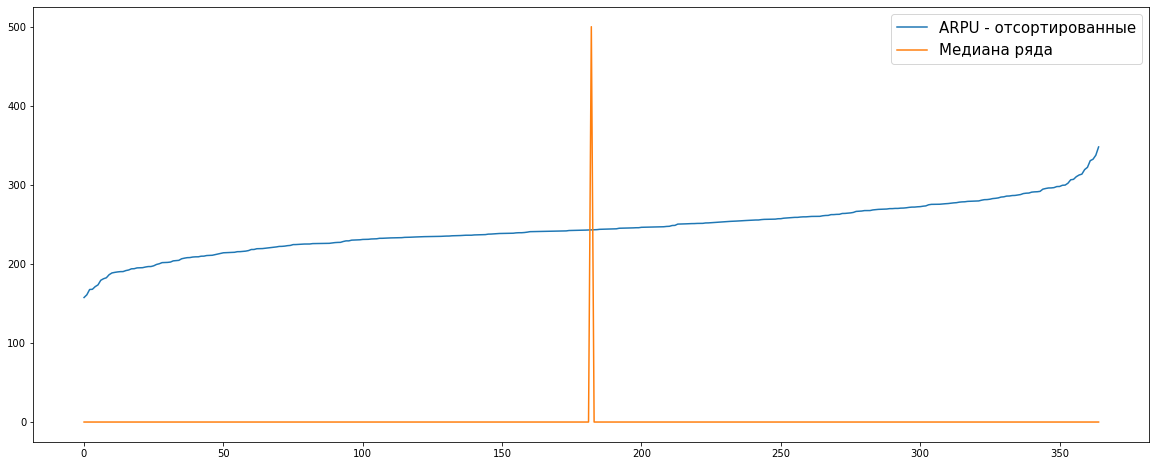

In [58]:
plt.figure(figsize = (20, 8))
plt.plot(ARPU['ARPU_sort'], label = 'ARPU - отсортированные' )
plt.plot(ARPU['Median'], label = 'Медиана ряда')
plt.legend(prop={'size': 15})

## Медиана
print(ARPU['ARPU_sort'].sort_values().median())

### Дисперсия и стандартное отклонение (ARPU)

In [59]:
# стандартное отклонение

ARPU['ARPU'].std()

31.307023472968755

In [60]:
# дисперсия

ARPU['ARPU'].var()

980.1297187370167

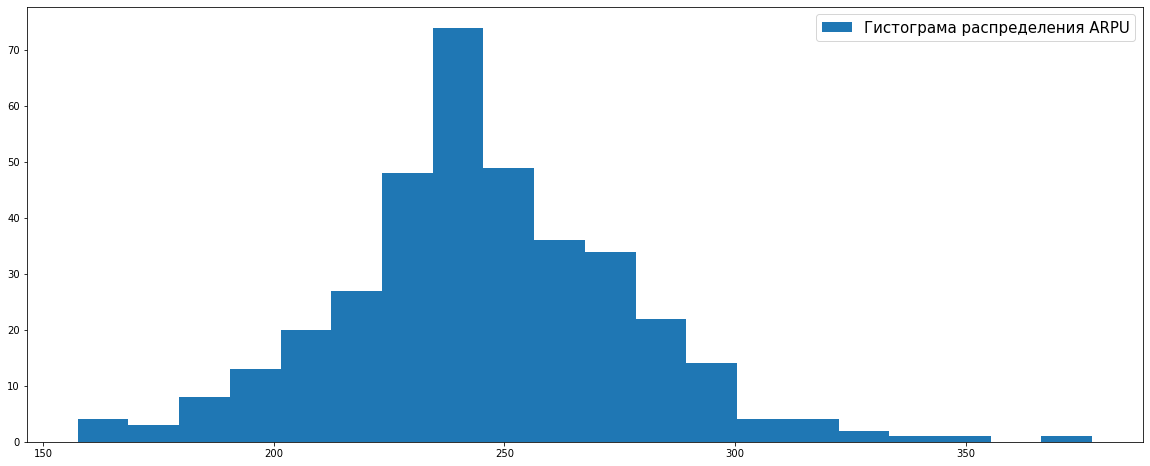

In [394]:
plt.figure(figsize = (20, 8))
plt.hist(ARPU['ARPU'], bins=20, label ='Гистограма распределения ARPU') 
plt.legend(prop={'size': 15})
plt.show()

Закон распределения можно отнести к нормальному, с учетом гистограммы выше, а также с учетом того, что медиана и среднее арифметическое приблизительно равны

### Квантили и выбросы (ARPU)

In [62]:
print('95% квантиль равен:')
ARPU['ARPU'].quantile(.95)


95% квантиль равен:


296.072

In [63]:
print('50% квантиль равен:')
ARPU['ARPU'].quantile(.5)

50% квантиль равен:


243.03

In [64]:
print('99% квантиль равен:')
ARPU['ARPU'].quantile(.99)

99% квантиль равен:


331.2024

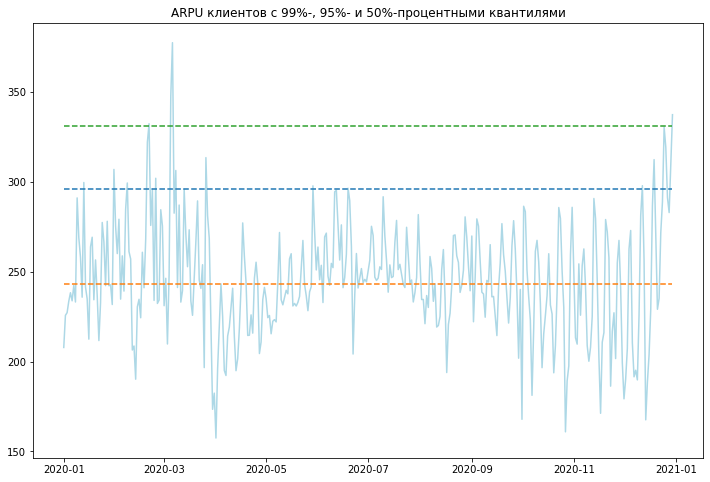

In [65]:
plt.figure(figsize = (12, 8))
plt.plot(ARPU['date'], ARPU['ARPU'], color = '#add8e6')
plt.plot((ARPU['date'][0], ARPU['date'].iloc[-1]), 
         (ARPU['ARPU'].quantile(.95), ARPU['ARPU'].quantile(.95)), label = 'Q1',
        ls = '--')



plt.plot((ARPU['date'][0], ARPU['date'].iloc[-1]), 
         (ARPU['ARPU'].quantile(.5), ARPU['ARPU'].quantile(.5)), label = 'Q1',
        ls = '--')

plt.plot((ARPU['date'][0], ARPU['date'].iloc[-1]), 
         (ARPU['ARPU'].quantile(.99), ARPU['ARPU'].quantile(.99)), label = 'Q1',
        ls = '--')
plt.title('ARPU клиентов с 99%-, 95%- и 50%-процентными квантилями')

plt.show()

 99% квантиль говорит нам о том, что ниже значения ARPU в **331** лежат 99% значений. Следовательно, те значения, которые мы видим на графике выше этого квантиля гарантировано являются выбросами в данной выборке.

Предположим, что 95% данных достаточно для того, чтобы утверждать, что они не являются выбросами. Исходя из этого значения, находящиеся выше **296** будем считать выбросами.

Найдем более точным методом аномалии с помощью Isolation Forest

In [66]:
# 95% квантиль с 5% доверительным интервалом

ARPU['label'] = [1 if (i < ARPU['ARPU'].quantile(.025)) or 
                      (i > ARPU['ARPU'].quantile(.975)) else 0 for i in ARPU['ARPU']]
ARPU

,date,ARPU,ARPU_sort,Median,label
index,,,,,
0,2020-01-01,207.87,157.47,0,0
1,2020-01-02,225.75,160.92,0,0
2,2020-01-03,227.24,167.59,0,0
3,2020-01-04,233.59,167.89,0,0
4,2020-01-05,238.33,171.24,0,0
...,...,...,...,...,...
360,2020-12-26,319.28,322.11,0,1
361,2020-12-27,291.26,330.54,0,0
362,2020-12-28,282.94,332.38,0,0


In [79]:
# разделим группы на тестовую и тренировочную выборки

X_2 = ARPU['ARPU'].to_numpy().reshape(-1, 1)
y_2 = ARPU['label']

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size = 0.1, random_state = 123)

In [80]:
# Создадим и обучим модель

i_for_2 = IsolationForest(n_estimators = 150, random_state = 123, bootstrap=True)
i_for_2.fit(X_train)

IsolationForest(bootstrap=True, n_estimators=150, random_state=123)

In [81]:
pred_train_2 = i_for_2.predict(X_train)
pred_test_2 = i_for_2.predict(X_test)

In [82]:
data_234 = pd.DataFrame(pred_test_2)
data_234['real'] = X_test
data_234

,0,real
0,1,275.45
1,1,225.82
2,1,268.96
3,1,230.03
4,1,253.05
5,1,269.39
6,-1,296.47
7,1,266.85
8,1,256.53
9,1,226.93


In [83]:
# выбросы ARPU
data_234[data_234[0]!=1] 

,0,real
6,-1,296.47
10,-1,277.17
16,-1,202.32
18,-1,209.73
20,-1,215.44
31,-1,283.45
33,-1,218.20
36,-1,286.45


_____
***

## ARPPU

In [84]:
# выгрузка данных ARPPU из BQ по дням
sql = """
SELECT  
    `date`,
    ROUND((SUM(`revenue`)/COUNT(DISTINCT  `clientId`)), 2)  ARPPU

FROM `astute-asset-303615.Project_3.ga_data`
WHERE `revenue` > 0 

GROUP BY 1
ORDER BY `date`

"""
ARPPU = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████| 366/366 [00:00<00:00, 1052.46rows/s]


In [179]:
# выгрузка данных ARPPU из BQ по месяцам
sql = """
SELECT  
    EXTRACT (MONTH FROM `date`) AS month,
    ROUND((SUM(`revenue`)/COUNT(DISTINCT  `clientId`)), 2)  ARPPU

FROM `astute-asset-303615.Project_3.ga_data`
WHERE `revenue` > 0

GROUP BY 1
ORDER BY 1


"""
ARPPU_2 = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████████| 12/12 [00:00<00:00, 36.79rows/s]


In [372]:
# выгрузка данных ARPPU из BQ по дням в период до короновирусной изоляции
sql = """
SELECT  
    `date`,
    ROUND((SUM(`revenue`)/COUNT(DISTINCT  `clientId`)), 2)  ARPPU

FROM `astute-asset-303615.Project_3.ga_data`
WHERE `revenue` > 0 AND `date` BETWEEN '2020-01-01' AND '2020-03-27'

GROUP BY 1
ORDER BY `date`

"""
ARPPU_before_lockdown = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|██████████████████████████| 87/87 [00:00<00:00, 282.72rows/s]


In [371]:
# выгрузка данных ARPPU из BQ по дням после короновирусной изоляции
sql = """
SELECT  
    `date`,
    ROUND((SUM(`revenue`)/COUNT(DISTINCT  `clientId`)), 2)  ARPPU

FROM `astute-asset-303615.Project_3.ga_data`
WHERE `revenue` > 0 AND `date` BETWEEN '2020-03-28' AND '2020-12-31'

GROUP BY 1
ORDER BY `date`

"""
ARPPU_after_lockdown = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|████████████████████████| 279/279 [00:00<00:00, 887.22rows/s]


In [86]:
ARPPU_2_grp = ARPPU_2.groupby(['month']).sum()
ARPPU_2_grp

,ARPPU
month,
1,1442.15
2,1480.97
3,1423.76
4,1286.16
5,1355.27
6,1370.09
7,1398.42
8,1369.81
9,1395.41


In [369]:
ARPPU_before_lockdown2 = ARPPU_before_lockdown.groupby('date').sum()

In [370]:
ARPPU_after_lockdown2 = ARPPU_after_lockdown.groupby('date').sum()

In [87]:
# Делаю групбай, чтобы построить график по датам

ARPPU_grp = ARPPU.groupby(['date']).sum()
ARPPU_grp

,ARPPU
date,
2020-01-01,1159.06
2020-01-02,1177.73
2020-01-03,1184.54
2020-01-04,1196.12
2020-01-05,1201.50
...,...
2020-12-27,1243.33
2020-12-28,1441.28
2020-12-29,1472.64


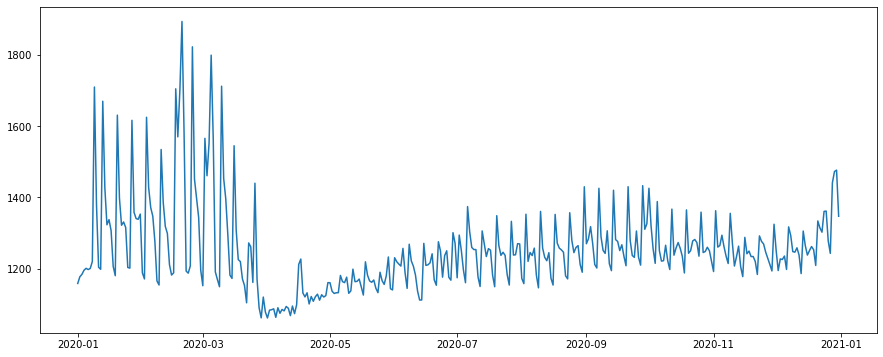

In [88]:
# построим график с целью ознакомления с метрикой по датам

plt.figure(figsize = (15, 6))
plt.plot(ARPPU_grp)

На графике наблюдается резкое падение значений по данной метрике в конце марта - начале апреля. Данный период можно охактеризовать началом короновирусной изоляции. В связи с этим, ARPPU необходимо в дальнейшем рассматривать в двух периодах: до локдауна и после.

Построим график ARPPU по дням

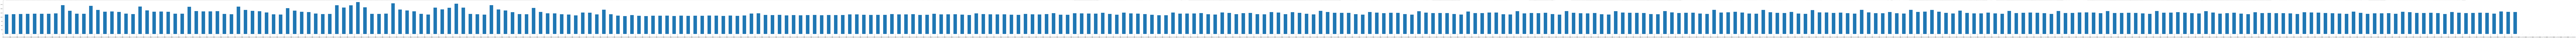

In [89]:
fig, ax = plt.subplots(figsize = (600, 8))
ax = ARPPU_grp['ARPPU'].plot(kind='bar',stacked=False)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
label_group_bar_table(ax, ARPPU_grp['ARPPU'])

# ДВОЙНОЙ КЛИК ПО ГРАФИКУ ДЛЯ ДЕТАЛЬНОГО ИЗУЧЕНИЯ

Построим график ARPPU по месяцам

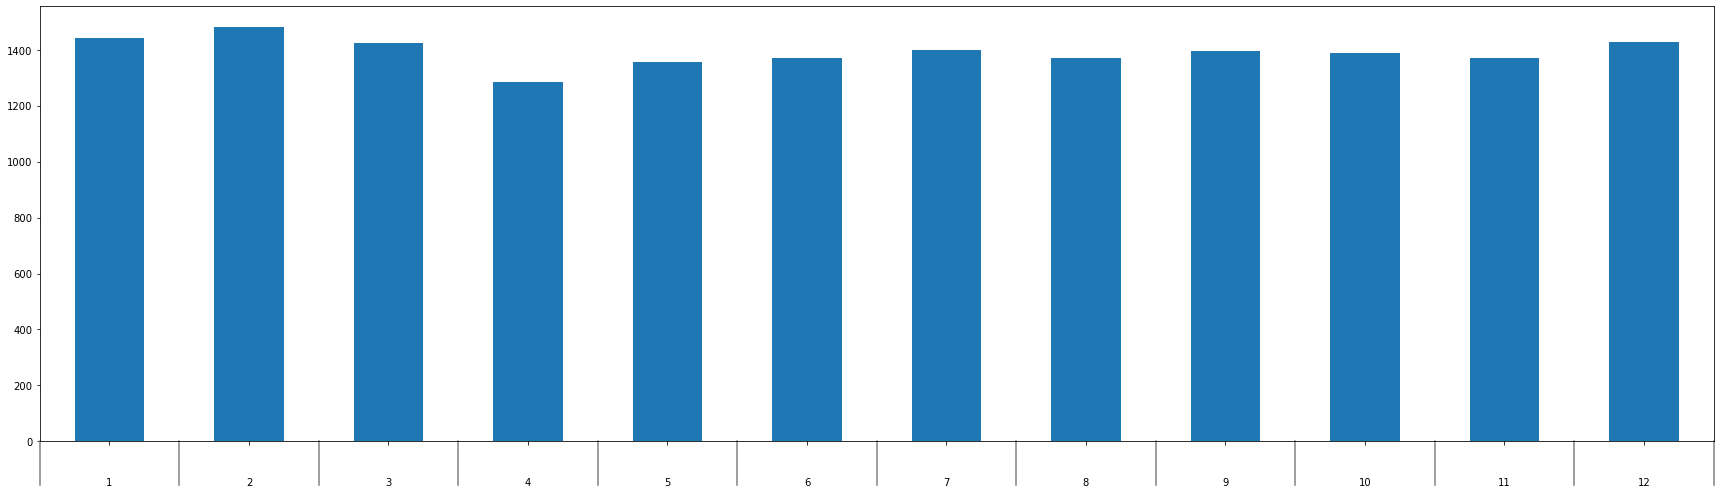

In [90]:
fig, ax = plt.subplots(figsize = (30, 8))
ax = ARPPU_2_grp['ARPPU'].plot(kind='bar',stacked=False)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
label_group_bar_table(ax, ARPPU_2_grp['ARPPU'])

### Среднее значение (ARPPU) до короновирусной изоляции

1343.1511494252873


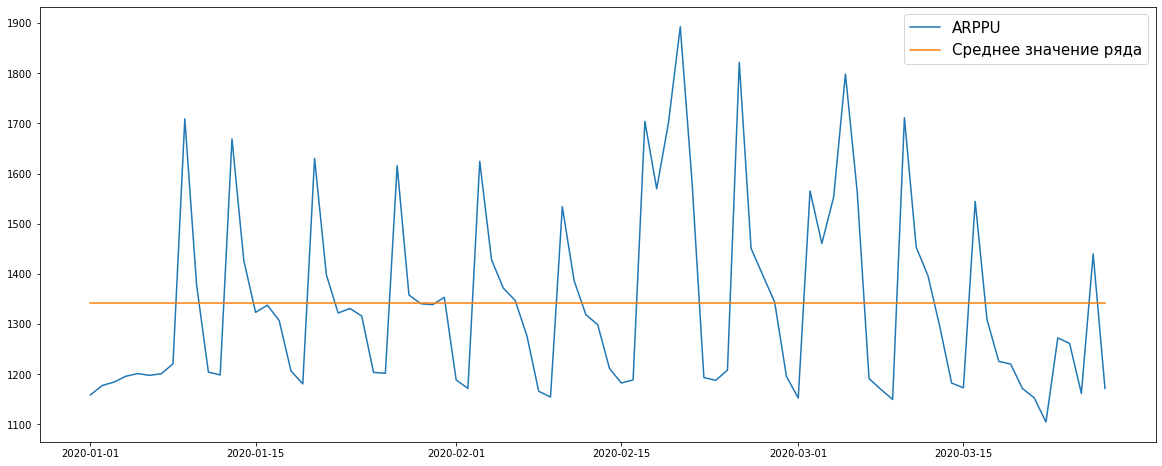

In [348]:
# добавил столбец средних значений в таблицу
ARPPU_before_lockdown['Mean'] = ARPPU_before_lockdown['ARPPU'].mean()
plt.figure(figsize = (20, 8))
# графики ARPPU и прямая среднего значения ряда
plt.plot(ARPPU_before_lockdown['ARPPU'], label = 'ARPPU' )
plt.plot(ARPPU_before_lockdown['Mean'], label = 'Среднее значение ряда')
plt.legend(prop={'size': 15})

## Среднее значение
print(ARPPU_before_lockdown['ARPPU'].sort_values().mean())

На графике выше можно наблюдать стабильные значения по ARPPU относительно среднего

### Среднее значение (ARPPU) во время короновирусной изоляции

1226.52458781362


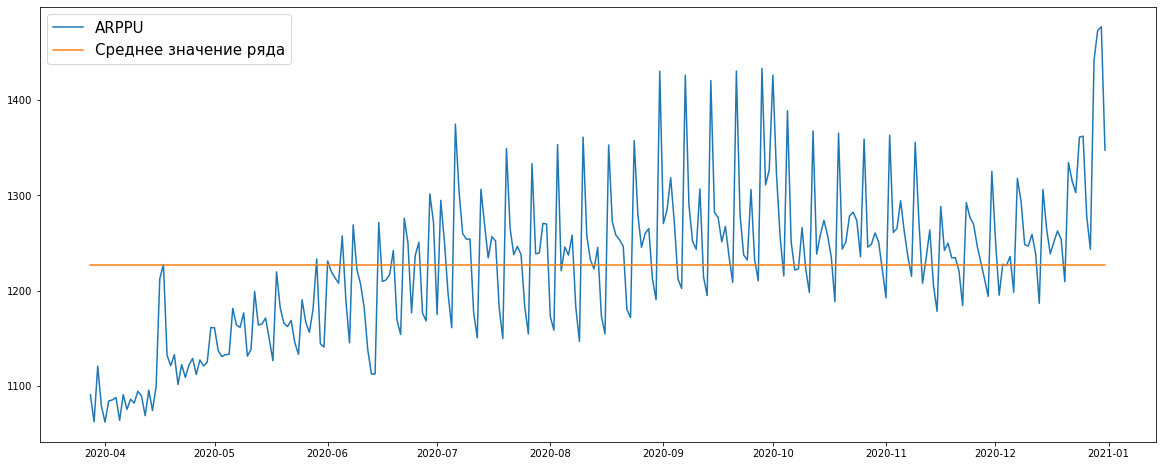

In [349]:
# добавил столбец средних значений в таблицу
ARPPU_after_lockdown['Mean'] = ARPPU_after_lockdown['ARPPU'].mean()
plt.figure(figsize = (20, 8))
# графики ARPPU и прямая среднего значения ряда
plt.plot(ARPPU_after_lockdown['ARPPU'], label = 'ARPPU' )
plt.plot(ARPPU_after_lockdown['Mean'], label = 'Среднее значение ряда')
plt.legend(prop={'size': 15})

## Среднее значение
print(ARPPU_after_lockdown['ARPPU'].sort_values().mean())

После изоляции, заметны скачкообразные изменения по верхнему и нижнему порогам в метрике, вызванные изоляцией. Также можно наблюдать на резкий рост метрики между апрелем и маем, вызванный использованием клиентами промоакций, в последующем компания ужесточила данную возможность и метрика выровнялась в своих значениях с июля по сентябрь.

### Медиана (ARPPU) до изоляции

In [357]:
print(ARPPU_before_lockdown['ARPPU'].sort_values().median())

1307.23


### Медиана (ARPPU) во время изоляции

In [358]:
print(ARPPU_after_lockdown['ARPPU'].sort_values().median())

1234.37


### Дисперсия и стандартное отклонение (ARPPU)

In [359]:
# стандартное отклонение до локдауна

ARPPU_before_lockdown['ARPPU'].std()

187.21349804388103

In [360]:
# дисперсия до локдауна
ARPPU_before_lockdown['ARPPU'].var()

35048.89384982625

In [362]:
# стандартное отклонения во время
ARPPU_after_lockdown['ARPPU'].std()

79.37185370250099

In [361]:
# дисперсияя во время изоляции

ARPPU_after_lockdown['ARPPU'].var()

6299.89116017122

### Графики распределения ARPPU до изоляции и во время изоляции с наложением

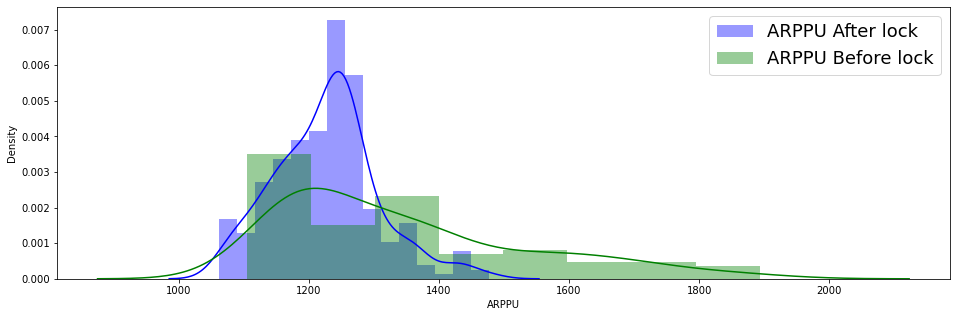

In [364]:
fig, axs = plt.subplots(1, 1, figsize=(16, 5))
sns.distplot((ARPPU_after_lockdown['ARPPU']),  color='b', label="ARPPU After lock")

sns.distplot((ARPPU_before_lockdown['ARPPU']),  color='g', label="ARPPU Before lock")
plt.legend(prop={'size': 18})

plt.show()

### Квантили и выбросы (ARPPU) до изоляции

In [365]:
print('95% квантиль равен:')
ARPPU_before_lockdown['ARPPU'].quantile(.95)


95% квантиль равен:


1707.8239999999998

In [366]:
print('50% квантиль равен:')
ARPPU_before_lockdown['ARPPU'].quantile(.5)

50% квантиль равен:


1307.23

In [367]:
print('99% квантиль равен:')
ARPPU_before_lockdown['ARPPU'].quantile(.99)

99% квантиль равен:


1831.9086

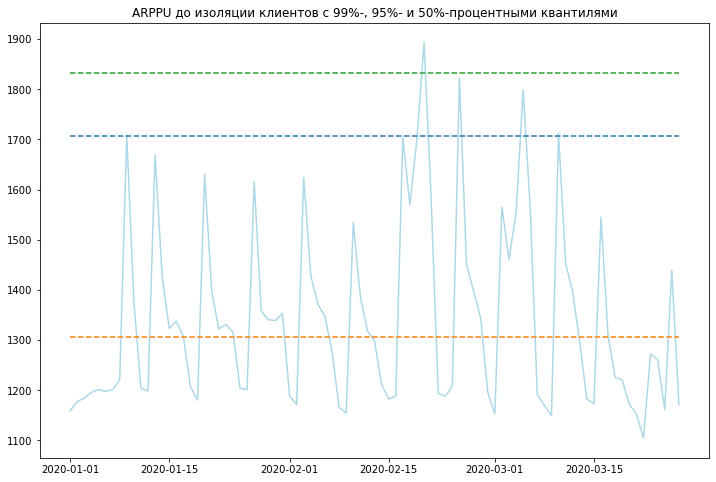

In [373]:
plt.figure(figsize = (12, 8))
plt.plot(ARPPU_before_lockdown['date'], ARPPU_before_lockdown['ARPPU'], color = '#add8e6')
plt.plot((ARPPU_before_lockdown['date'][0], ARPPU_before_lockdown['date'].iloc[-1]), 
         (ARPPU_before_lockdown['ARPPU'].quantile(.95), ARPPU_before_lockdown['ARPPU'].quantile(.95)), label = 'Q1',
        ls = '--')



plt.plot((ARPPU_before_lockdown['date'][0], ARPPU_before_lockdown['date'].iloc[-1]), 
         (ARPPU_before_lockdown['ARPPU'].quantile(.5), ARPPU_before_lockdown['ARPPU'].quantile(.5)), label = 'Q1',
        ls = '--')

plt.plot((ARPPU_before_lockdown['date'][0], ARPPU_before_lockdown['date'].iloc[-1]), 
         (ARPPU_before_lockdown['ARPPU'].quantile(.99), ARPPU_before_lockdown['ARPPU'].quantile(.99)), label = 'Q1',
        ls = '--')
plt.title('ARPPU до изоляции клиентов с 99%-, 95%- и 50%-процентными квантилями')

plt.show()

 99% квантиль говорит нам о том, что ниже значения ARPU равного **1707** лежат 99% значений. Следовательно, те значения, которые мы видим на графике выше этого квантиля гарантировано являются выбросами в данной выборке.

Предположим, что 95% данных достаточно для того, чтобы утверждать, что они не являются выбросами. Исходя из этого значения, находящиеся выше **1831** будем считать выбросами.

Найдем более точным методом аномалии с помощью Isolation Forest

In [374]:
# 95% квантиль с 5% доверительным интервалом (5/2 = 2.5%)

ARPPU_before_lockdown['label'] = [1 if (i < ARPPU_before_lockdown['ARPPU'].quantile(.025)) or 
                      (i > ARPPU_before_lockdown['ARPPU'].quantile(.975)) else 0 for i in ARPPU_before_lockdown['ARPPU']]
ARPPU_before_lockdown

,date,ARPPU,label
0,2020-01-01,1159.06,0
1,2020-01-02,1177.73,0
2,2020-01-03,1184.54,0
3,2020-01-04,1196.12,0
4,2020-01-05,1201.50,0
...,...,...,...
82,2020-03-23,1272.58,0
83,2020-03-24,1261.68,0
84,2020-03-25,1161.97,0
85,2020-03-26,1439.91,0


In [375]:
# разделим группы на тестовую и тренировочную выборки

X_3 = ARPPU_before_lockdown['ARPPU'].to_numpy().reshape(-1, 1)
y_3 = ARPPU_before_lockdown['label']

X_train, X_test, y_train, y_test = train_test_split(X_3, y_3, test_size = 0.1, random_state = 123)

In [376]:
# Создадим и обучим модель

i_for_3 = IsolationForest(n_estimators = 150, random_state = 123, bootstrap=True)
i_for_3.fit(X_train)

IsolationForest(bootstrap=True, n_estimators=150, random_state=123)

In [377]:
pred_train_3 = i_for_3.predict(X_train)
pred_test_3 = i_for_3.predict(X_test)

In [378]:
# присвоим выбросам значение -1 из столбца "лейбл", и 1 не выбросам 

data_456 = pd.DataFrame(pred_test_3)
data_456['real'] = X_test
data_456

,0,real
0,1,1201.50
1,-1,1161.97
2,-1,1451.21
3,-1,1371.72
4,1,1182.69
5,1,1340.72
6,-1,1396.25
7,1,1187.95
8,-1,1153.11


In [379]:
# выбросы ARPPU
data_456[data_456[0]!=1] 

,0,real
1,-1,1161.97
2,-1,1451.21
3,-1,1371.72
6,-1,1396.25
8,-1,1153.11


### Квантили и выбросы (ARPPU) во время изоляции

In [380]:
print('95% квантиль равен:')
ARPPU_after_lockdown['ARPPU'].quantile(.95)

95% квантиль равен:


1361.9479999999999

In [381]:
print('50% квантиль равен:')
ARPPU_after_lockdown['ARPPU'].quantile(.5)

50% квантиль равен:


1234.37

In [382]:
print('99% квантиль равен:')
ARPPU_after_lockdown['ARPPU'].quantile(.99)

99% квантиль равен:


1434.8215999999998

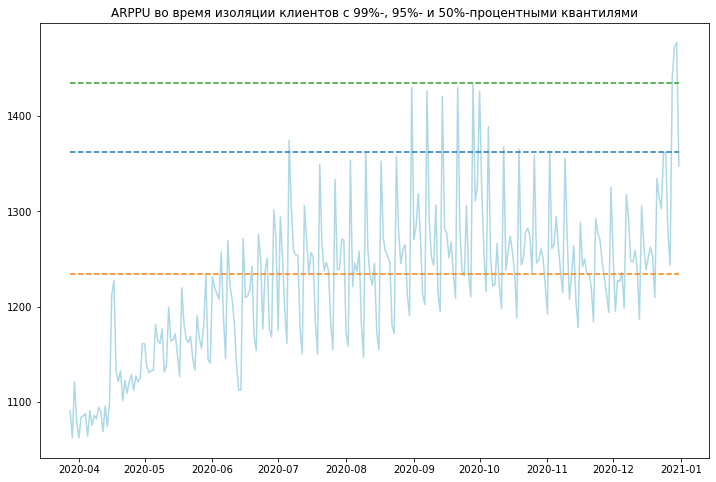

In [383]:
plt.figure(figsize = (12, 8))
plt.plot(ARPPU_after_lockdown['date'], ARPPU_after_lockdown['ARPPU'], color = '#add8e6')
plt.plot((ARPPU_after_lockdown['date'][0], ARPPU_after_lockdown['date'].iloc[-1]), 
         (ARPPU_after_lockdown['ARPPU'].quantile(.95), ARPPU_after_lockdown['ARPPU'].quantile(.95)), label = 'Q1',
        ls = '--')



plt.plot((ARPPU_after_lockdown['date'][0], ARPPU_after_lockdown['date'].iloc[-1]), 
         (ARPPU_after_lockdown['ARPPU'].quantile(.5), ARPPU_after_lockdown['ARPPU'].quantile(.5)), label = 'Q1',
        ls = '--')

plt.plot((ARPPU_after_lockdown['date'][0], ARPPU_after_lockdown['date'].iloc[-1]), 
         (ARPPU_after_lockdown['ARPPU'].quantile(.99), ARPPU_after_lockdown['ARPPU'].quantile(.99)), label = 'Q1',
        ls = '--')
plt.title('ARPPU во время изоляции клиентов с 99%-, 95%- и 50%-процентными квантилями')

plt.show()

In [384]:
# 95% квантиль с 5% доверительным интервалом (5/2 = 2.5%)

ARPPU_after_lockdown['label'] = [1 if (i < ARPPU_after_lockdown['ARPPU'].quantile(.025)) or 
                      (i > ARPPU_after_lockdown['ARPPU'].quantile(.975)) else 0 for i in ARPPU_after_lockdown['ARPPU']]
ARPPU_after_lockdown

,date,ARPPU,label
0,2020-03-28,1090.87,0
1,2020-03-29,1062.68,1
2,2020-03-30,1120.99,0
3,2020-03-31,1079.22,1
4,2020-04-01,1062.40,1
...,...,...,...
274,2020-12-27,1243.33,0
275,2020-12-28,1441.28,1
276,2020-12-29,1472.64,1
277,2020-12-30,1476.58,1


In [386]:
# разделим группы на тестовую и тренировочную выборки

X_8 = ARPPU_after_lockdown['ARPPU'].to_numpy().reshape(-1, 1)
y_8 = ARPPU_after_lockdown['label']
X_train, X_test, y_train, y_test = train_test_split(X_8, y_8, test_size = 0.1, random_state = 123)

In [387]:
# Создадим и обучим модель

i_for_8 = IsolationForest(n_estimators = 150, random_state = 123, bootstrap=True)
i_for_8.fit(X_train)

IsolationForest(bootstrap=True, n_estimators=150, random_state=123)

In [388]:
pred_train_8 = i_for_8.predict(X_train)
pred_test_8 = i_for_8.predict(X_test)

In [389]:
# присвоим выбросам значение -1 из столбца "лейбл", и 1 не выбросам 

data_987 = pd.DataFrame(pred_test_8)
data_987['real'] = X_test
data_987

,0,real
0,-1,1292.29
1,-1,1101.69
2,-1,1145.29
3,1,1260.95
4,1,1272.21
5,1,1258.08
6,1,1248.30
7,1,1245.75
8,1,1250.63
9,-1,1131.08


In [391]:
# выбросы ARPPU во время изоляции
data_987[data_987[0]!=1] 

,0,real
0,-1,1292.29
1,-1,1101.69
2,-1,1145.29
9,-1,1131.08
11,-1,1112.23
14,-1,1121.11
17,-1,1127.45
18,-1,1289.91
22,-1,1348.93
27,-1,1154.68


## ROI

In [113]:
ROI

,medium,source,month,ROI
0,cpa,admitad,1,778.841958
1,cpa,admitad,2,789.546706
2,cpa,admitad,3,762.592190
3,cpa,admitad,4,779.985768
4,cpa,admitad,5,768.122772
5,cpa,admitad,6,791.880355
6,cpa,admitad,7,762.950043
7,cpa,admitad,8,753.351064
8,cpa,admitad,9,742.357508
9,cpa,admitad,10,763.738944


Построим график с группировкой по месяцам и источникам для определения тенденций в поведении ROI, предварительно произведя группировку данных

In [114]:
ROI_grp = ROI.groupby(['month', 'source']).sum()
ROI_grp

ROI
month source             
1     admitad  778.841958
      google   824.431579
      yandex   701.448801
2     admitad  789.546706
      google   848.128611
      yandex   702.025717
3     admitad  762.592190
      google   781.846276
      yandex   684.820384
4     admitad  779.985768
      google   666.456515
      yandex   559.621965
5     admitad  768.122772
      google   717.947688
      yandex   685.422601
6     admitad  791.880355
      google   640.399137
      yandex   640.544460
7     admitad  762.950043
      google   629.174461
      yandex   596.907557
8     admitad  753.351064
      google   543.591316
      yandex   513.749895
9     admitad  742.357508
      google   529.815940
      yandex   496.563741
10    admitad  763.738944
      google   488.650730
      yandex   447.182900
11    admitad  739.530466
      google   565.271567
      yandex   447.425970
12    admitad  729.998557
      google   568.847975
      yandex   546.532240

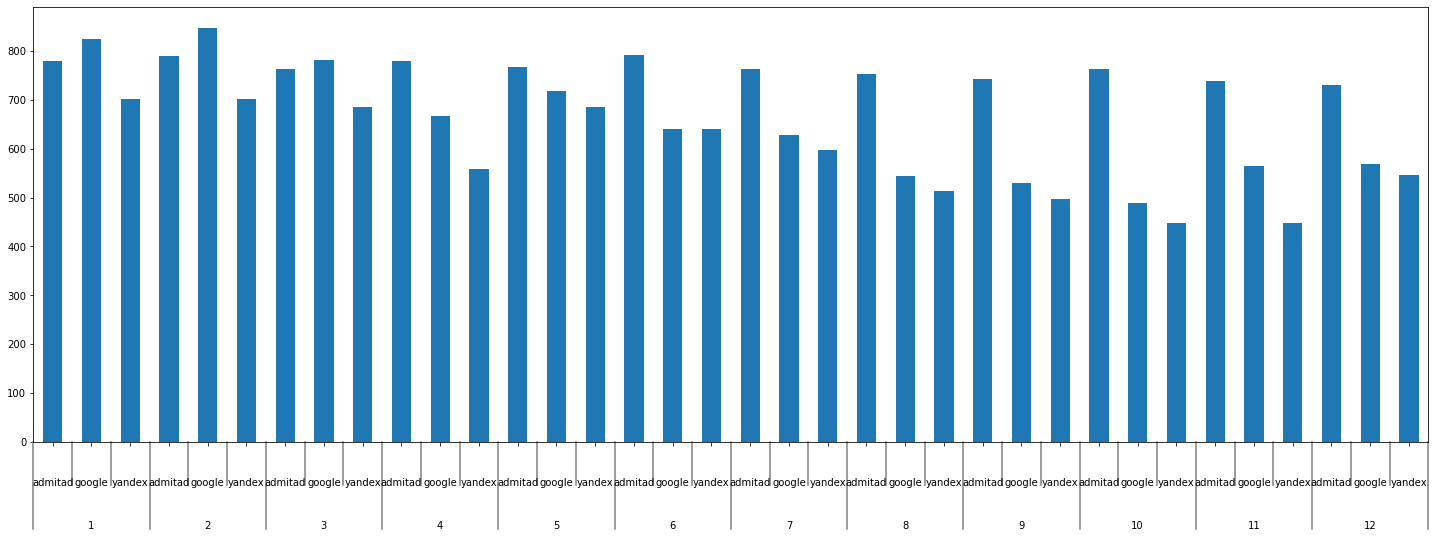

In [115]:
fig, ax = plt.subplots(figsize = (25, 8))
ax = ROI_grp['ROI'].plot(kind='bar',stacked=False)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
label_group_bar_table(ax, ROI_grp['ROI'])

# ДВОЙНОЙ КЛИК ПО ГРАФИКУ ДЛЯ ДЕТАЛЬНОГО ИЗУЧЕНИЯ

По предварительной оценке графика можно сделать вывод о том, что показатель ROI для источника "admitad" из месяца в месяц имеет стабильные показатели. В свою очередь ROI у "google" и "yandex" к концу года значительно упали

In [126]:
ROI_g = ROI.groupby(['month']).mean()
ROI['Mean'] = ROI['ROI'].mean()


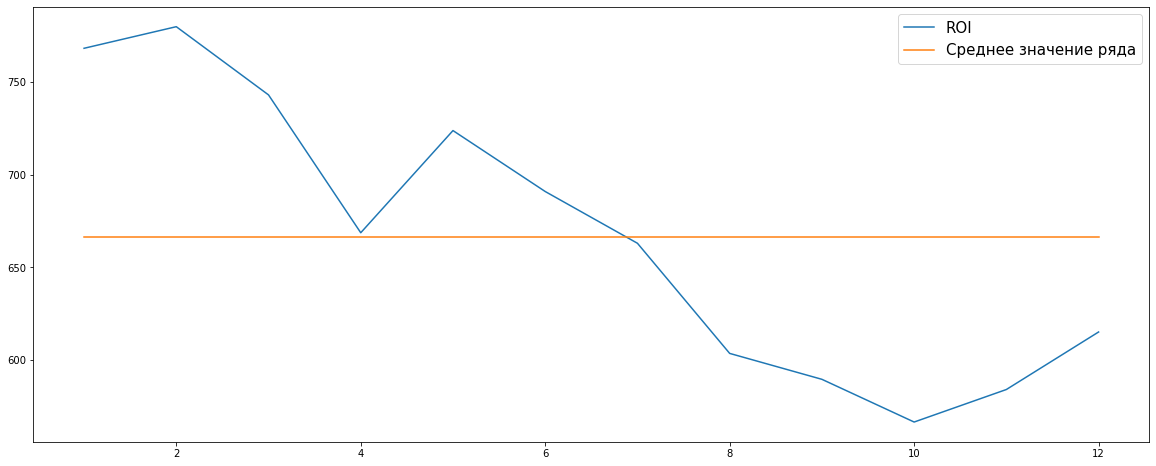

In [130]:
# График поведения ROI относительно среднего значения

plt.figure(figsize = (20, 8))
# графики ROI и прямая среднего значения ряда
plt.plot(ROI_g['ROI'], label = 'ROI' )
plt.plot(ROI_g['Mean'], label = 'Среднее значение ряда')
plt.legend(prop={'size': 15})


### Медиана (ROI)

In [139]:
# Создаю свой столбец с индексами и обозначаю их индексами всей таблицы
ROI['Index'] = range(0, 36, 1)
ROI.index = ROI['Index']
ROI = ROI.drop(['Index'], axis =1 )
# сортирую значения для поиска медианы
ROI['ROI_sort'] = ROI['ROI'].sort_values(ignore_index=True)
# удаляю один столбец, чтобы их было нечетное количество для определения целочисленного порядкового номера
ROI_m = ROI.drop([35], axis = 'index')
ROI_m

,medium,source,month,ROI,Mean,ROI_sort
Index,,,,,,
0,cpa,admitad,1,778.841958,666.380677,447.182900
1,cpa,admitad,2,789.546706,666.380677,447.425970
2,cpa,admitad,3,762.592190,666.380677,488.650730
3,cpa,admitad,4,779.985768,666.380677,496.563741
4,cpa,admitad,5,768.122772,666.380677,513.749895
5,cpa,admitad,6,791.880355,666.380677,529.815940
6,cpa,admitad,7,762.950043,666.380677,543.591316
7,cpa,admitad,8,753.351064,666.380677,546.532240
8,cpa,admitad,9,742.357508,666.380677,559.621965


In [140]:
# номер индекса в таблице, где находится медианное значение

(len(ROI_m['ROI_sort'])-1)/2

17.0

In [141]:
# соответствие номера индекса и отсортированного значения ROI и есть медиана

ROI_m[ROI_m['ROI_sort'] == ROI_m['ROI_sort'].median()]

,medium,source,month,ROI,Mean,ROI_sort
Index,,,,,,
17,cpc,google,6,640.399137,666.380677,685.422601


### Дисперсия и стандартное отклонение (ROI)

In [142]:
# стандартное отклонение

ROI['ROI'].std()

114.80609030486785

In [143]:
# дисперсия

ROI['ROI'].var()

13180.438371089473

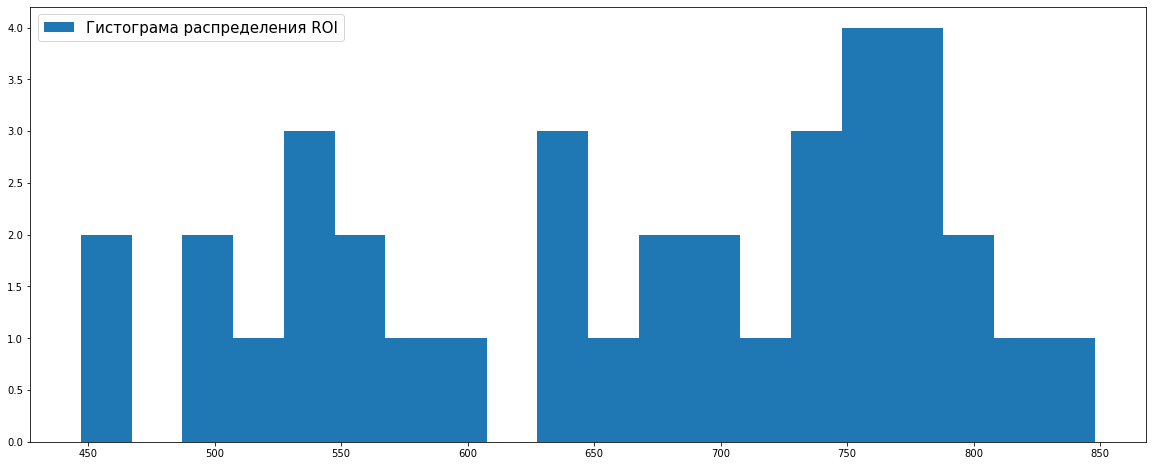

In [392]:
plt.figure(figsize = (20, 8))
plt.hist(ROI['ROI'], bins=20, label ='Гистограма распределения ROI') 
plt.legend(prop={'size': 15})
plt.show()

Распределение метрики ROI отклоняется от нормального, исходя из графика выше

Поиск выбросов по данной метрике, считаю нецелесообразным, т.к. изучается она в разрезе по месяцам и любое отклонение от среднего значения можно считать особенностью рассматриваемого случая, а не выбросом

In [212]:
CPA6 = CPA[['month', 'CPA_google_yandex_admitad']].groupby(['month']).sum()

In [213]:
# объединяю все метрики, которые были проанализированы по месяцам
# не получилось сделать мердж сразу нескольких таблиц, поэтому делаю по очереди)
ALL = ARPPU_2_grp.merge(ARPU_2_grp, on = 'month')
ALL = ALL.merge(CPA6, on = 'month')

In [214]:
ROI6 = ROI[['month', 'ROI']]
ROI6 = ROI6.groupby('month').sum()

Также стоит выгрузить данные по транзакциям, т.к. они напрямую связаны с ARPU и ARPPU

In [220]:
# запрос на выгрузку транзакций
sql = """
SELECT 
EXTRACT (MONTH FROM `date`) AS month,
SUM(transactions) as transactions
 FROM `astute-asset-303615.Project_3.ga_data` 
GROUP BY 1
ORDER BY 1
"""
transactions = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████████| 12/12 [00:00<00:00, 39.06rows/s]


In [222]:
tr = transactions.groupby('month').sum()

In [225]:
# формирую запрос на количество платящих клиентов по месяцам
sql = """
SELECT 
EXTRACT (MONTH FROM `date`) AS month,
COUNT(clientId) as pay_count
 FROM `astute-asset-303615.Project_3.ga_data` 
WHERE transactions > 0
GROUP BY 1
ORDER BY 1
"""
pay = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████████| 12/12 [00:00<00:00, 40.32rows/s]


In [230]:
pay.groupby(['month']).sum()

,pay_count
month,
1,105843
2,121956
3,122773
4,128199
5,130872
6,119766
7,106802
8,104670
9,100482


In [240]:
# формирую запрос на количество НЕ платящих клиентов по месяцам
sql = """
SELECT 
EXTRACT (MONTH FROM `date`) AS month,
COUNT(clientId) as non_pay_count
 FROM `astute-asset-303615.Project_3.ga_data` 
WHERE transactions = 0
GROUP BY 1
ORDER BY 1
"""
non_pay = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████████| 12/12 [00:00<00:00, 39.14rows/s]


In [242]:
non_pay.groupby(['month']).sum()

,non_pay_count
month,
1,506606
2,594338
3,551587
4,593290
5,594997
6,534891
7,491556
8,506652
9,496631


In [243]:
ALL1 = ALL.merge(ROI6, on = 'month')
ALL2 = ALL1.merge(tr, on = 'month')

In [257]:
# выгружу данные по доходу по месяцам
sql = """
SELECT 
EXTRACT (MONTH FROM `date`) AS month,
SUM(revenue) as revenue
 FROM `astute-asset-303615.Project_3.ga_data` 
GROUP BY 1
ORDER BY 1
"""
revenue = pandas_gbq.read_gbq(sql, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████████| 12/12 [00:00<00:00, 42.38rows/s]


In [259]:
revenue = revenue.groupby(['month']).sum()
revenue

,revenue
month,
1,1.362115e+08
2,1.615039e+08
3,1.544335e+08
4,1.416920e+08
5,1.512228e+08
6,1.435918e+08
7,1.314085e+08
8,1.288563e+08
9,1.269169e+08


In [260]:
ALL3 = ALL2.merge(pay, on = 'month')
ALL4 = ALL3.merge(non_pay, on = 'month')
# введем столбец с количеством повторных транзакций
ALL4['more_than_one'] = ALL4['transactions'] - ALL4['pay_count']
# индекс в месяц
ALL4.index = ALL4['month']
ALL4 = ALL4.drop(['month'], axis =1 )
# переименовываю длинное название
ALL4 = ALL4.rename(columns = {'CPA_google_yandex_admitad' : 'CPA'})
# добавил данныые по доходам
ALL5 = ALL4.merge(revenue, on = 'month')
ALL5

,ARPPU,ARPU,CPA,ROI,transactions,pay_count,non_pay_count,more_than_one,revenue
month,,,,,,,,,
1,1442.15,298.43,214277.14,2304.722338,108017,105843,506606,2174,1.362115e+08
2,1480.97,315.79,310826.32,2339.701034,124549,121956,594338,2593,1.615039e+08
3,1423.76,318.53,272263.56,2229.258850,125405,122773,551587,2632,1.544335e+08
4,1286.16,276.13,275486.98,2006.064247,130219,128199,593290,2020,1.416920e+08
5,1355.27,297.52,255635.11,2171.493061,132889,130872,594997,2017,1.512228e+08
6,1370.09,314.83,255933.81,2072.823953,121787,119766,534891,2021,1.435918e+08
7,1398.42,310.13,217408.99,1989.032061,108565,106802,491556,1763,1.314085e+08
8,1369.81,293.14,215135.26,1810.692276,106075,104670,506652,1405,1.288563e+08
9,1395.41,298.68,207731.58,1768.737188,101868,100482,496631,1386,1.269169e+08


Построим график корреляции с целью определения взаимосвязей между метриками из сводной таблицы для анализа

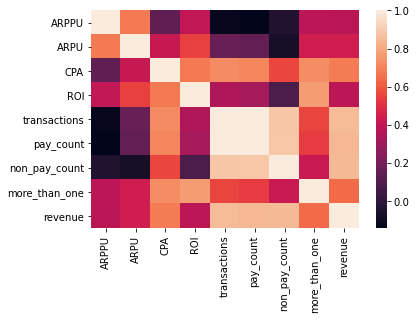

In [261]:
sns.heatmap(ALL5.corr())
plt.show()

____
***
## Выводы
К концу анализируемого периода (года) наблюдается падение **ROI** кампании. 

Рекордными по доходам месяцами являются февраль, март и май. В эти месяцы наблюдается прирост по повторным транзакциям, рост числа как платящих, так и не платящих пользователей, соответственный прирост количества транзакций. Данные изменения вызваны, вероятнее всего, повышением затрат на рекламную кампанию, с увеличением её эффективности, что подтверждает столбец **СРА**. Стоит отметить, что изменений в продукте или его цене произведено не было. **ROI** демонстрирует эффективность.

Также, стоит обратить внимание на 12 месяц, в котором наблюдается максимальный доход с ростом не платящих клиентов, с ростом транзакций и платящих клиентов, а также понижением повторных транзакций. Опираясь на **ROI**, можно смело сказать, что соотношение доходов и расходов в этом месяце одно из самых худших. Можно сделать вывод о нерентабельности рекламной кампании, а повышение дохода объяснить снижением цены или повышением качества товара. 


__________
***

## **Спрогнозировать доход на следующий месяц (январь 2021) в детализации по дням.**


Т.к. данные имеют два периода до ковидных ограничений/во время ковидных ограничений, то возможно переобучение модели. Поэтому для прогнозирования дохода на следующий месяц, лучше задействовать данные за более поздний период, а именно с момента начала ограничений, который мы приняли с 2020-03-28

In [1]:
# Загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [3]:
train_data = pd.read_csv('ML2.csv')
train_data

,date,pageviews,visits,transactions,revenue,productClick,addToCart,checkout,promo_activated,filter_used
0,2020-03-28,2,1,0,0.0,10,2,1,0,0
1,2020-03-28,1,1,0,0.0,0,0,0,0,0
2,2020-03-28,1,1,0,0.0,0,0,0,0,0
3,2020-03-28,1,1,0,0.0,0,0,0,0,0
4,2020-03-28,3,1,0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
6133073,2020-11-02,1,1,0,0.0,0,0,0,0,0
6133074,2020-11-02,3,1,0,0.0,0,0,0,0,0
6133075,2020-11-02,1,1,0,0.0,0,0,0,0,0
6133076,2020-11-02,10,2,0,0.0,0,0,0,1,0


In [4]:
train_data.corr()

,pageviews,visits,transactions,revenue,productClick,addToCart,checkout,promo_activated,filter_used
pageviews,1.000000,0.025275,0.407868,0.351456,0.637652,0.638060,0.678939,0.392076,0.128192
visits,0.025275,1.000000,0.006013,0.004511,0.013829,0.013831,0.016153,0.023500,0.002863
transactions,0.407868,0.006013,1.000000,0.758899,0.432785,0.431725,0.484223,0.178347,0.043661
revenue,0.351456,0.004511,0.758899,1.000000,0.441223,0.440278,0.380155,0.136054,0.043710
productClick,0.637652,0.013829,0.432785,0.441223,1.000000,0.999291,0.598509,0.307928,0.102283
addToCart,0.638060,0.013831,0.431725,0.440278,0.999291,1.000000,0.598103,0.307889,0.102326
checkout,0.678939,0.016153,0.484223,0.380155,0.598509,0.598103,1.000000,0.360913,0.075367
promo_activated,0.392076,0.023500,0.178347,0.136054,0.307928,0.307889,0.360913,1.000000,0.042400
filter_used,0.128192,0.002863,0.043661,0.043710,0.102283,0.102326,0.075367,0.042400,1.000000


### Этап предобработки данных

In [6]:
# удалил ненужный с точки зрения обучения столбцы


train_data = train_data.drop(['visits'], axis = 1) # слабо коррелирует
train_data = train_data.drop(['promo_activated'], axis = 1)
train_data = train_data.drop(['filter_used'], axis = 1)
train_data = train_data.drop(['checkout'], axis = 1)
train_data = train_data.drop(['pageviews'], axis = 1)
train_data

,date,transactions,revenue,productClick,addToCart
0,2020-03-28,0,0.0,10,2
1,2020-03-28,0,0.0,0,0
2,2020-03-28,0,0.0,0,0
3,2020-03-28,0,0.0,0,0
4,2020-03-28,0,0.0,0,0
...,...,...,...,...,...
6133073,2020-11-02,0,0.0,0,0
6133074,2020-11-02,0,0.0,0,0
6133075,2020-11-02,0,0.0,0,0
6133076,2020-11-02,0,0.0,0,0


In [8]:
train_data = train_data.drop(['date'], axis = 1)

In [11]:
# Объявляю переменные после преобразования признаков
X_5 = train_data.drop('revenue', axis = 1)
y_5 = train_data['revenue']

In [12]:
# делю данные на тестовые и тренировочные группы
X_train, X_test, y_train, y_test = train_test_split(X_5, y_5, test_size = .2, random_state = 123)

In [13]:
# унифицирую масштабы значений
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [14]:
# добавляю отмасштабированные значения в тренировочную и тестовую группы
X_train_sc = pd.DataFrame(X_train_sc,columns=list(X_train))
X_test_sc = pd.DataFrame(X_test_sc,columns=list(X_test))

### Обучение моделей

In [15]:
# Линейная регрессия
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, make_scorer, f1_score
# Кросс-валидация
from sklearn.model_selection import cross_val_score
# mse
from sklearn.metrics import mean_squared_error

In [16]:
# Обучаю модель
lin_reg = LinearRegression()

lin_reg.fit(X_train_sc, y_train)

LinearRegression()

In [295]:
# предсказание значений линейной регрессии
preds = lin_reg.predict(X_test)

In [296]:
df1 = pd.DataFrame(preds)
df1

,0
0,-2.471385e+09
1,-3.326182e+09
2,-2.769812e+09
3,-2.471385e+09
4,-3.326184e+09
...,...
153558,-3.027758e+09
153559,-3.326181e+09
153560,-3.326184e+09
153561,-3.027755e+09


_____
***

## **Провести кластерный анализ (с любыми признаками на ваше усмотрение).**

Произведем кластерный анализ наличия доставки из используемой базы данных.

In [18]:
train_data2 = pd.read_csv('ML.csv')
train_data2

,date,source,medium,delivery_available,pageviews,visits,transactions,revenue,productClick,addToCart,checkout
0,2020-12-01,yandex,cpc,Доставка есть,8,1,0,0,20,4,3
1,2020-12-01,google,cpc,Не определено,6,1,0,0,10,2,3
2,2020-12-01,yandex,organic,Не определено,4,1,0,0,0,0,2
3,2020-12-01,(direct),(none),Не определено,4,1,0,0,0,0,0
4,2020-12-01,google,cpc,Не определено,3,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
767806,2020-12-31,yandex,cpc,Не определено,19,1,0,0,30,6,13
767807,2020-12-31,(direct),(none),Не определено,0,1,1,2694,0,0,0
767808,2020-12-31,(direct),(none),Не определено,0,1,1,1145,0,0,0
767809,2020-12-31,(direct),(none),Не определено,0,1,1,878,0,0,0


In [19]:
# Определим имя анализируемой переменной как "Х"
X = train_data2['delivery_available']
X

0         Доставка есть
1         Не определено
2         Не определено
3         Не определено
4         Не определено
              ...      
767806    Не определено
767807    Не определено
767808    Не определено
767809    Не определено
767810    Не определено
Name: delivery_available, Length: 767811, dtype: object

In [20]:
# Преобразую категориальную переменную Х в float
dum2 = pd.get_dummies(X, drop_first = True)
dum2

,Доставки нет,Не определено
0,0,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
767806,0,1
767807,0,1
767808,0,1
767809,0,1


In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [22]:
# масштабирую переменную после преобразования
X_scale = sc.fit_transform(dum2)

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

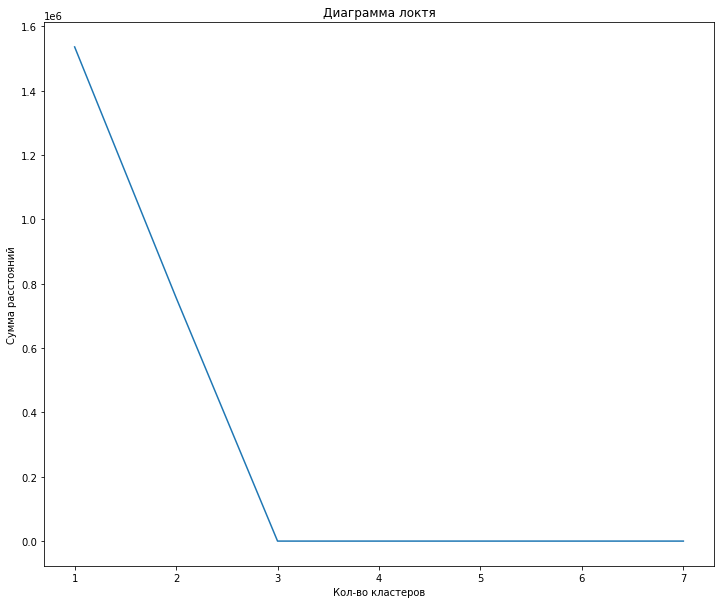

In [23]:
# ищу количество кластеров при помощи диаграммы локтя
error = []
for k in range(1, 8):
    k_means = KMeans(n_clusters = k, random_state = 123)
    k_means.fit(X_scale)
    error.append(k_means.inertia_)
    plt.figure(figsize=(12, 10))
plt.title('Диаграмма локтя')
plt.plot(range(1, 8), error)
plt.xlabel('Кол-во кластеров')
plt.ylabel('Сумма расстояний')
plt.show()

По итогам построения диграммы локтя, установлено количество кластеров в размере трех.

In [30]:
km = KMeans(n_clusters = 3)

ff = km.fit(X_scale)

# Сумма расстояний от объектов до кластеров
km.inertia_

# Массив с кластером каждой точки
clusters = km.labels_

total_df = pd.DataFrame(X_scale)
total_df['cluster'] = clusters

total_df

,0,1,cluster
0,-0.045854,-2.642674,1
1,-0.045854,0.378405,0
2,-0.045854,0.378405,0
3,-0.045854,0.378405,0
4,-0.045854,0.378405,0
...,...,...,...
767806,-0.045854,0.378405,0
767807,-0.045854,0.378405,0
767808,-0.045854,0.378405,0
767809,-0.045854,0.378405,0


In [56]:
total_df['cluster'].value_counts()

0    671639
1     94561
2      1611
Name: cluster, dtype: int64